# Orignalny kod

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import haversine_distances
from math import radians


In [4]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [5]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [6]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [7]:
class DKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        parameter_values = []

        
        stats_dict = {}
        
        for index, param in enumerate(self.parameters()):
            stats_dict['mean_var_median' + str(index)] = []
            
                        
            
        
        
        for epoch in range(num_epochs):
            for index, param in enumerate(self.parameters()):
                param_value = param.detach().numpy()
                stats_dict['mean_var_median' + str(index)].append([np.mean(param_value), np.var(param_value), np.median(param_value)])                      

            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
            
        return history, stats_dict
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

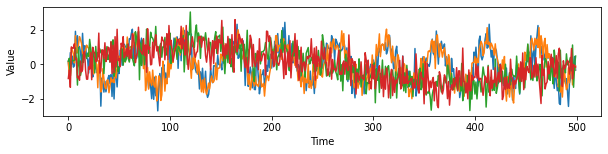

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [9]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [10]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [11]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 4.163, mse= 3.828, kld= 3.354
	val_loss= 4.171, val_mse= 3.910, val_kld= 2.609
Epoch= 11/200, loss= 3.523, mse= 3.474, kld= 0.493
	val_loss= 3.676, val_mse= 3.618, val_kld= 0.583
Epoch= 21/200, loss= 3.090, mse= 3.014, kld= 0.764
	val_loss= 3.270, val_mse= 3.165, val_kld= 1.053
Epoch= 31/200, loss= 2.867, mse= 2.778, kld= 0.894
	val_loss= 3.000, val_mse= 2.921, val_kld= 0.797
Epoch= 41/200, loss= 2.388, mse= 2.280, kld= 1.079
	val_loss= 2.478, val_mse= 2.396, val_kld= 0.818
Epoch= 51/200, loss= 2.212, mse= 2.098, kld= 1.132
	val_loss= 2.259, val_mse= 2.143, val_kld= 1.164
Epoch= 61/200, loss= 2.107, mse= 1.992, kld= 1.144
	val_loss= 1.807, val_mse= 1.705, val_kld= 1.012
Epoch= 71/200, loss= 1.871, mse= 1.768, kld= 1.028
	val_loss= 1.971, val_mse= 1.865, val_kld= 1.054
Epoch= 81/200, loss= 1.755, mse= 1.653, kld= 1.022
	val_loss= 1.747, val_mse= 1.646, val_kld= 1.011
Epoch= 91/200, loss= 1.662, mse= 1.562, kld= 0.992
	val_loss= 1.585, val_mse= 1.493, val_kld= 0.917
E

<AxesSubplot:xlabel='Epoch'>

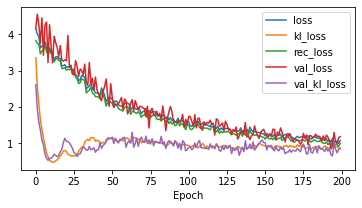

In [12]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

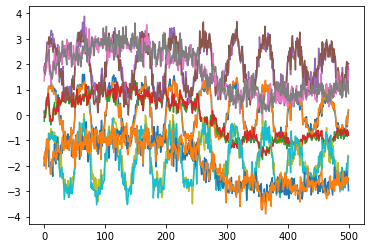

In [13]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

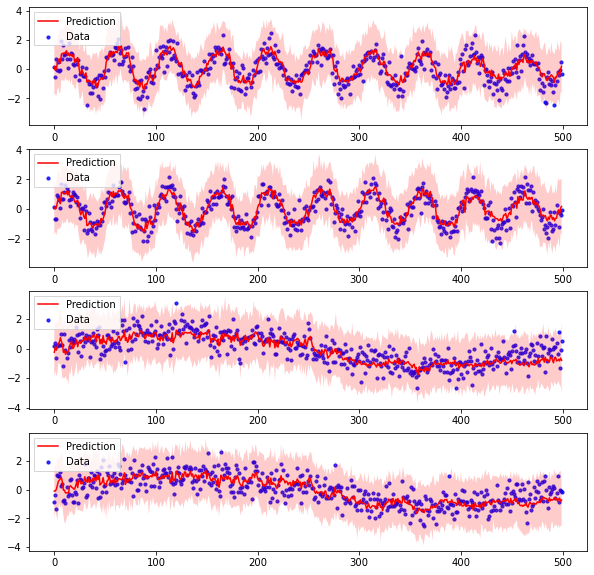

In [14]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

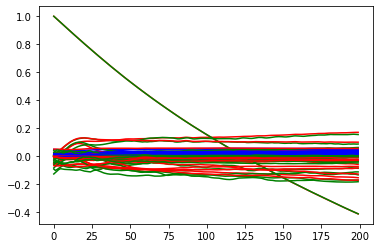

In [15]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

# Moja praca

## Wczytanie danych

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import torch

In [17]:


#FIRST on 10 000 workouts - train 9000, test 1000
data_endo = []
i = 0
#with gzip.open('endomondoHR.json.gz') as f:

with open('endomondoHR_proper.json') as f:
    for l in f:
        i += 1
        #print(i)
        data_endo.append(eval(l))
        if i == 10000:
            break
        #print(data[0])

## Wstępne wykresy

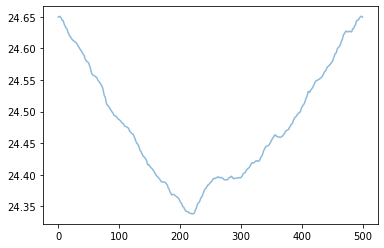

In [18]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

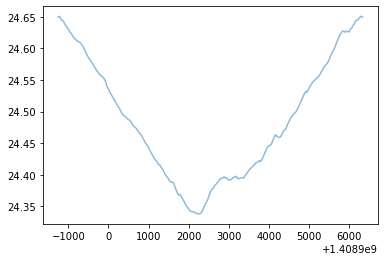

In [19]:

# Plot timestamp x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


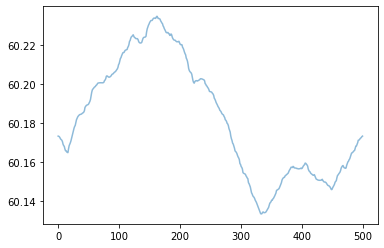

In [20]:

# Plot ithmeasurement x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

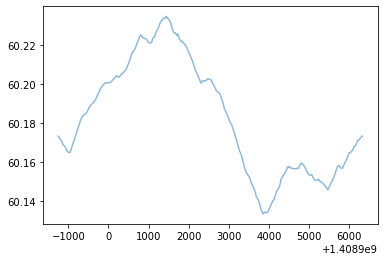

In [21]:

# Plot timestamp x latitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['latitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)


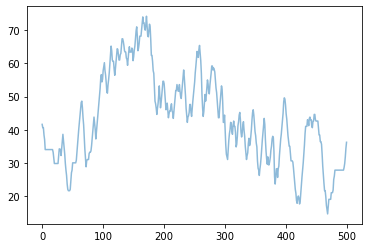

In [22]:

# Plot ithmeasurement x altitude

#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

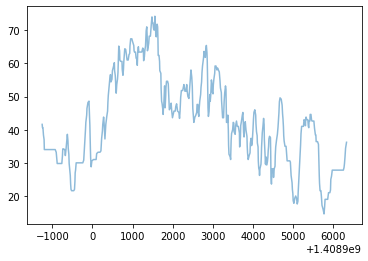

In [23]:

# Plot timestamp x altitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['altitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii



x = np.asarray(data_endo[0]['timestamp'])


plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

In [24]:
####OK wykresy sie zgadzaja

In [25]:
###TERAZ TRENUJEMY DLA 1 WORKOUTU LONGITUDE,TRAIN TO PIERWSZE 450 A VAL TO KOLEJNE 50

In [24]:
#### ITHMEASUREMENT vs LONGITUDE

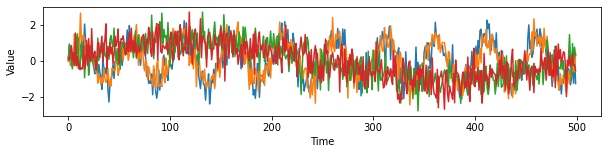

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [26]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)
#print(data.shape[1])

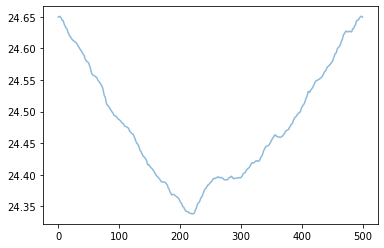

In [27]:

# Plot ithmeasurement x longitude



#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)

## Trenowane dla 1 treningu po longitude

In [32]:
#x = torch.FloatTensor(data).reshape(1, *data.shape)
#x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])

y_data = torch.FloatTensor(y).reshape(1, 500, 1)
#print(y_data)
y_train = torch.FloatTensor(y[:450]).reshape(1, 450, 1)
#print(y_train)
y_val = torch.FloatTensor(y[450:500]).reshape(1, 50, 1)
#print(y_val)


In [33]:
dkf = DKF(input_dim=1, z_dim=5, rnn_dim=5, trans_dim=5, emission_dim=5)

In [34]:
history, param_dict = dkf.fit(y_train, y_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 609.565, mse= 609.060, kld= 5.051
	val_loss= 606.549, val_mse= 606.194, val_kld= 3.551
Epoch= 11/200, loss= 593.252, mse= 593.116, kld= 1.361
	val_loss= 604.587, val_mse= 604.445, val_kld= 1.420
Epoch= 21/200, loss= 531.615, mse= 531.407, kld= 2.080
	val_loss= 538.189, val_mse= 537.962, val_kld= 2.266
Epoch= 31/200, loss= 140.203, mse= 139.373, kld= 8.300
	val_loss= 71.422, val_mse= 69.680, val_kld= 17.418
Epoch= 41/200, loss= 27.100, mse= 26.725, kld= 3.756
	val_loss= 29.652, val_mse= 29.257, val_kld= 3.949
Epoch= 51/200, loss= 10.490, mse= 10.204, kld= 2.854
	val_loss= 7.213, val_mse= 6.887, val_kld= 3.264
Epoch= 61/200, loss= 4.125, mse= 3.914, kld= 2.111
	val_loss= 4.940, val_mse= 4.675, val_kld= 2.653
Epoch= 71/200, loss= 2.446, mse= 2.200, kld= 2.452
	val_loss= 5.792, val_mse= 5.489, val_kld= 3.034
Epoch= 81/200, loss= 2.836, mse= 2.590, kld= 2.462
	val_loss= 4.688, val_mse= 4.369, val_kld= 3.189
Epoch= 91/200, loss= 2.146, mse= 1.928, kld= 2.181
	val_loss= 3.

<AxesSubplot:xlabel='Epoch'>

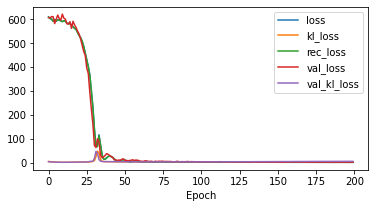

In [35]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

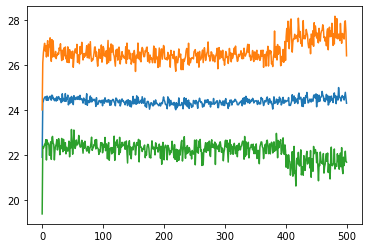

In [36]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(y_data, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

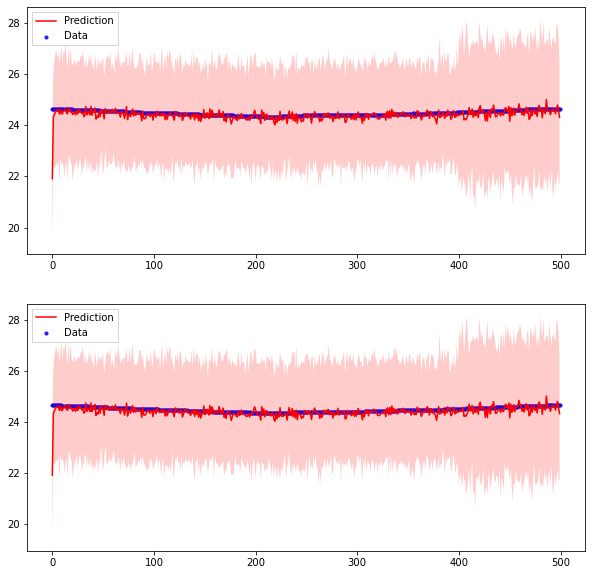

In [37]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(y.shape[0]),
        y[:], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, 0], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, 0], x_975[:, 0],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [38]:

mse_values = mean_squared_error(y_data[0], x_hat)
r_squared_values = r2_score(y_data[0], x_hat)
mae_values = mean_absolute_error(y_data[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(y_data[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(y_data[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(y_data[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

print(x_hat.shape)

              MSE  R-squared       MAE
Average  0.035344  -3.183149  0.118508
              MSE  R-squared       MAE
sample1  0.035344  -3.183149  0.118508
(500, 1)


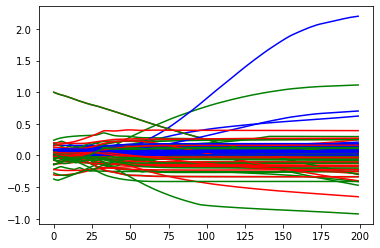

In [39]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [40]:
###################################################################################################################

In [41]:
####################################################################################################################

In [42]:
#TUTAJ TRENUJEMY DKF'a dla 1szego WORKOUTU 3 na RAZ LON LAT ALT

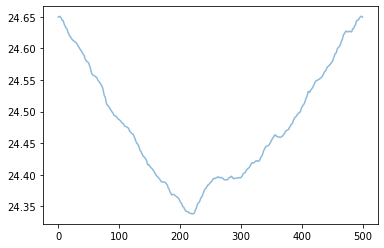

(500, 3)


In [43]:

# Plot ithmeasurement x longitude


#print(data_endo[0].keys())
y=np.asarray(data_endo[0]['longitude'])
z=np.asarray(data_endo[0]['latitude'])
x =[]
#print(len(x))
data_t = []
for i in range(len(y)):
    x.append(i)
    data_t.append((x[i], y[i]))
#print(data_t)
data_t = np.asarray(data_t)
#colors = np.random.rand(N)
#area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.plot(x, y, alpha=0.5)
plt.show()
#print(y.shape)





first_workout_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[0]['latitude']), np.asarray(data_endo[0]['altitude'])]).T
print(first_workout_data.shape)

## Trenowane dla pierwszego treningu po longitude, latitude i altitude

In [44]:
x = torch.FloatTensor(first_workout_data).reshape(1, *first_workout_data.shape)
#print(x)
x_train = torch.FloatTensor(first_workout_data[:450]).reshape(1, 450, first_workout_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(first_workout_data[450:500]).reshape(1, 50, first_workout_data.shape[1])
#print(x_val)

In [45]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [46]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2137.991, mse= 2126.206, kld= 117.855
	val_loss= 1648.675, val_mse= 1646.222, val_kld= 24.528
Epoch= 11/200, loss= 1256.645, mse= 1248.165, kld= 84.806
	val_loss= 728.850, val_mse= 722.706, val_kld= 61.433
Epoch= 21/200, loss= 59.002, mse= 54.734, kld= 42.677
	val_loss= 107.794, val_mse= 103.569, val_kld= 42.250
Epoch= 31/200, loss= 77.736, mse= 74.301, kld= 34.354
	val_loss= 136.987, val_mse= 133.483, val_kld= 35.035
Epoch= 41/200, loss= 43.736, mse= 41.256, kld= 24.799
	val_loss= 91.683, val_mse= 88.787, val_kld= 28.960
Epoch= 51/200, loss= 45.020, mse= 43.201, kld= 18.186
	val_loss= 86.446, val_mse= 83.956, val_kld= 24.898
Epoch= 61/200, loss= 41.355, mse= 39.687, kld= 16.675
	val_loss= 95.323, val_mse= 93.070, val_kld= 22.526
Epoch= 71/200, loss= 40.994, mse= 39.573, kld= 14.206
	val_loss= 95.193, val_mse= 93.190, val_kld= 20.035
Epoch= 81/200, loss= 40.424, mse= 39.185, kld= 12.389
	val_loss= 86.212, val_mse= 84.338, val_kld= 18.746
Epoch= 91/200, loss= 39.880,

<AxesSubplot:xlabel='Epoch'>

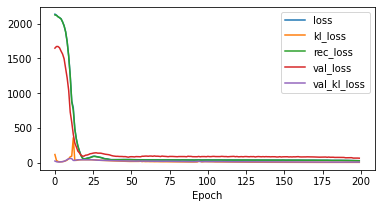

In [47]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

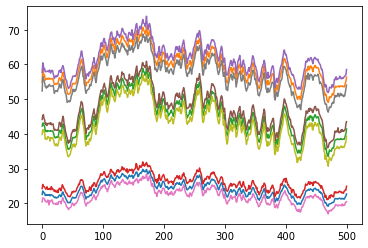

In [48]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

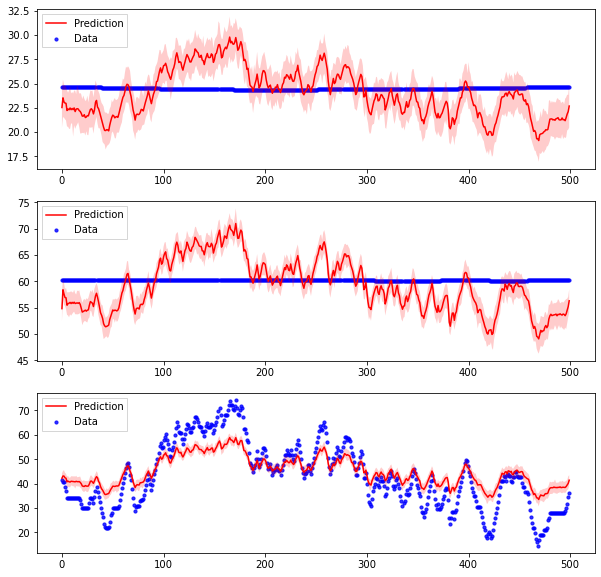

In [49]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(first_workout_data.shape[0]),
        first_workout_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [50]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE    R-squared       MAE
Average  30.811045 -9595.493595  4.282147
               MSE     R-squared       MAE
sample1   6.431111   -760.156997  2.136508
sample2  25.136131 -28026.988624  4.201183
sample3  60.865898      0.664835  6.508749


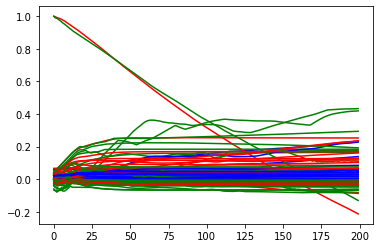

In [51]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
###################################################################################################################

In [ ]:
####################################################################################################################

In [ ]:
#TERAZ DKF DLA LONGITUDE DLA 3 PIERWSZYCH WORKOUTOW

## Trenowane dla 3 pierwszych treningow po longitude

In [52]:
longitude_three_data = np.vstack([np.asarray(data_endo[0]['longitude']), np.asarray(data_endo[1]['longitude']), np.asarray(data_endo[2]['longitude'])]).T
#print(first_workout_data.shape)

In [53]:
x = torch.FloatTensor(longitude_three_data).reshape(1, *longitude_three_data.shape)
#print(x)
x_train = torch.FloatTensor(longitude_three_data[:450]).reshape(1, 450, longitude_three_data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(longitude_three_data[450:500]).reshape(1, 50, longitude_three_data.shape[1])
#print(x_val)

In [54]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [55]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 633.595, mse= 617.423, kld= 161.721
	val_loss= 618.901, val_mse= 615.115, val_kld= 37.855
Epoch= 11/200, loss= 297.543, mse= 296.320, kld= 12.231
	val_loss= 217.358, val_mse= 215.741, val_kld= 16.168
Epoch= 21/200, loss= 55.305, mse= 54.663, kld= 6.426
	val_loss= 43.157, val_mse= 42.225, val_kld= 9.317
Epoch= 31/200, loss= 14.258, mse= 13.761, kld= 4.968
	val_loss= 11.982, val_mse= 11.076, val_kld= 9.056
Epoch= 41/200, loss= 6.076, mse= 5.571, kld= 5.051
	val_loss= 7.917, val_mse= 6.979, val_kld= 9.378
Epoch= 51/200, loss= 4.762, mse= 4.434, kld= 3.280
	val_loss= 4.390, val_mse= 3.630, val_kld= 7.596
Epoch= 61/200, loss= 2.693, mse= 2.396, kld= 2.963
	val_loss= 3.893, val_mse= 3.126, val_kld= 7.674
Epoch= 71/200, loss= 2.195, mse= 1.921, kld= 2.737
	val_loss= 2.698, val_mse= 1.877, val_kld= 8.218
Epoch= 81/200, loss= 1.911, mse= 1.678, kld= 2.330
	val_loss= 2.650, val_mse= 1.922, val_kld= 7.274
Epoch= 91/200, loss= 1.654, mse= 1.430, kld= 2.243
	val_loss= 1.976, val

<AxesSubplot:xlabel='Epoch'>

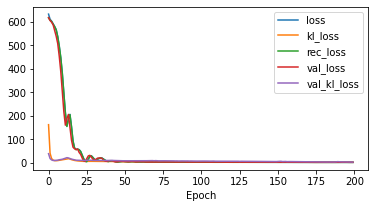

In [56]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

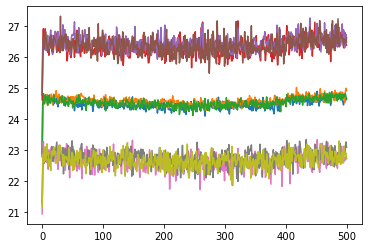

In [57]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

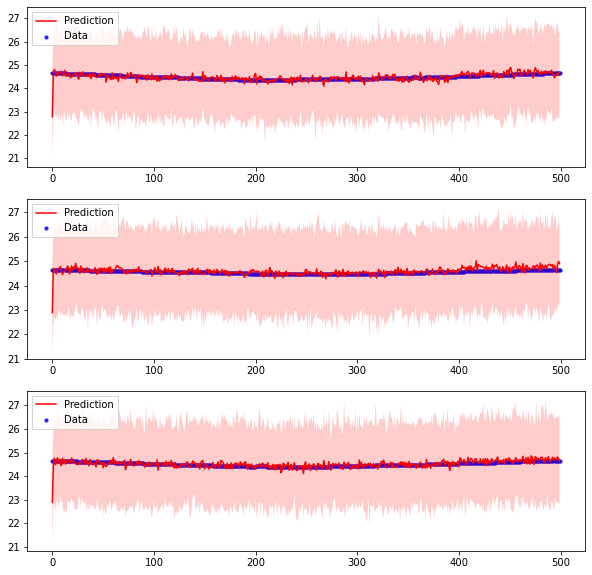

In [58]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(longitude_three_data.shape[0]),
        longitude_three_data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [59]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  0.017611  -2.137534  0.087514
              MSE  R-squared       MAE
sample1  0.017798  -1.106433  0.084893
sample2  0.017971  -3.747880  0.089084
sample3  0.017065  -1.558291  0.088566


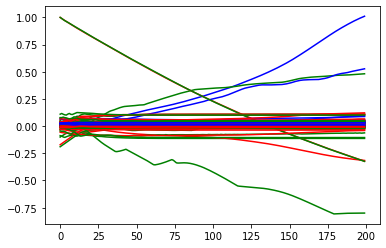

In [60]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
####################################################################################################################

In [ ]:
####################################################################################################################

In [ ]:
#TUTAJ DKF PO ALTITUDE DLA 5 WORKOUTOW

## Trenowane dla 5 pierwszych treningow po altitude

In [61]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

In [62]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

In [63]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [64]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 1989.756, mse= 1964.765, kld= 249.905
	val_loss= 828.705, val_mse= 827.090, val_kld= 16.153
Epoch= 11/200, loss= 453.677, mse= 449.086, kld= 45.911
	val_loss= 144.426, val_mse= 141.169, val_kld= 32.564
Epoch= 21/200, loss= 168.490, mse= 165.855, kld= 26.354
	val_loss= 92.657, val_mse= 89.861, val_kld= 27.963
Epoch= 31/200, loss= 105.231, mse= 102.795, kld= 24.359
	val_loss= 38.923, val_mse= 36.388, val_kld= 25.351
Epoch= 41/200, loss= 85.490, mse= 83.526, kld= 19.633
	val_loss= 31.391, val_mse= 29.146, val_kld= 22.449
Epoch= 51/200, loss= 80.925, mse= 79.280, kld= 16.445
	val_loss= 23.711, val_mse= 21.704, val_kld= 20.065
Epoch= 61/200, loss= 79.985, mse= 78.460, kld= 15.250
	val_loss= 25.174, val_mse= 23.573, val_kld= 16.011
Epoch= 71/200, loss= 79.053, mse= 77.857, kld= 11.961
	val_loss= 24.048, val_mse= 22.808, val_kld= 12.402
Epoch= 81/200, loss= 77.559, mse= 76.207, kld= 13.528
	val_loss= 21.416, val_mse= 20.224, val_kld= 11.925
Epoch= 91/200, loss= 77.166, mse

<AxesSubplot:xlabel='Epoch'>

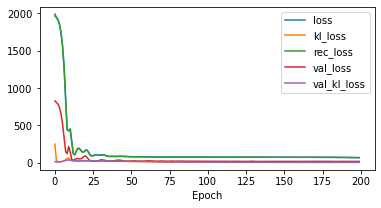

In [65]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

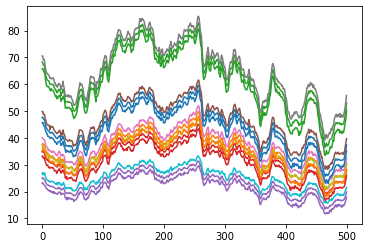

In [66]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

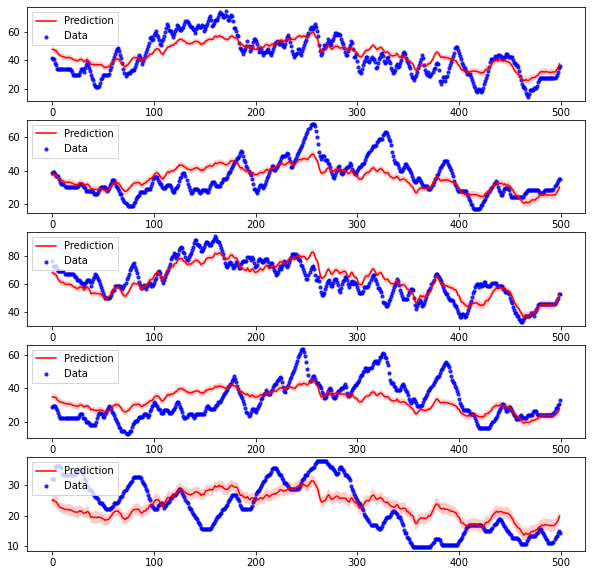

In [67]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [68]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  62.864613   0.478931  6.402478
               MSE  R-squared       MAE
sample1  63.101223   0.652526  6.758931
sample2  59.574207   0.446659  5.932997
sample3  51.535629   0.705010  5.830832
sample4  89.060036   0.316807  7.526007
sample5  51.051968   0.273654  5.963626


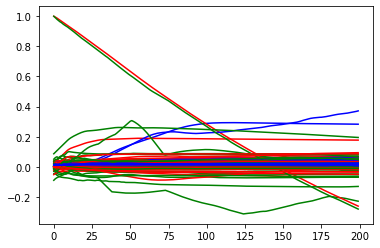

In [69]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
####################################################################################################################

In [ ]:
#Preparing test synthetic datasets - each 1000 measurements

# Przygotowanie danych syntetycznych

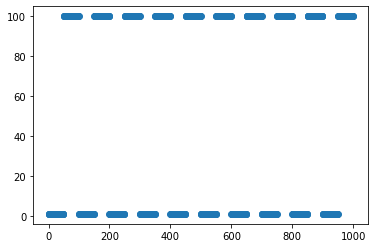

In [70]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000])
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



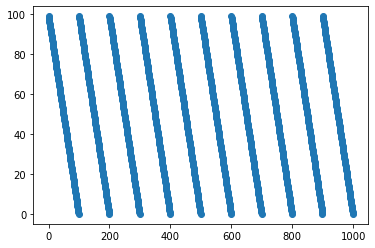

In [71]:
#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

In [72]:
#Dataset 3 - Growing from 1 to 100 then from 100 to 1

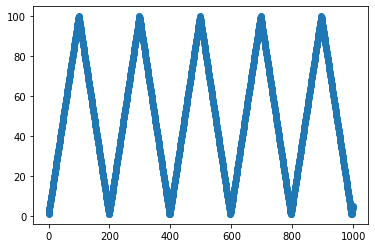

In [73]:
data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

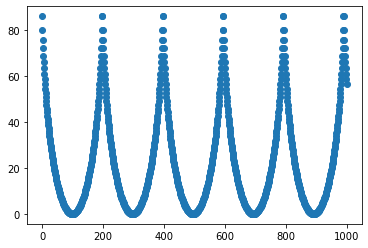

In [74]:
#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

In [75]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

In [76]:
data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)

## Trenowanie dla danych syntetycznych

In [77]:
dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [78]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 6117.203, mse= 3209.053, kld= 14540.748
	val_loss= 3176.538, val_mse= 3148.563, val_kld= 139.872
Epoch= 11/200, loss= 2726.004, mse= 2717.518, kld= 42.432
	val_loss= 2561.604, val_mse= 2546.139, val_kld= 77.321
Epoch= 21/200, loss= 1129.696, mse= 1122.428, kld= 36.343
	val_loss= 1065.781, val_mse= 1058.985, val_kld= 33.979
Epoch= 31/200, loss= 1001.916, mse= 996.810, kld= 25.527
	val_loss= 1006.467, val_mse= 1001.305, val_kld= 25.809
Epoch= 41/200, loss= 791.160, mse= 785.361, kld= 28.995
	val_loss= 752.302, val_mse= 746.351, val_kld= 29.751
Epoch= 51/200, loss= 407.302, mse= 401.078, kld= 31.123
	val_loss= 378.340, val_mse= 372.099, val_kld= 31.207
Epoch= 61/200, loss= 277.994, mse= 272.483, kld= 27.557
	val_loss= 267.741, val_mse= 262.279, val_kld= 27.311
Epoch= 71/200, loss= 164.073, mse= 159.104, kld= 24.845
	val_loss= 144.851, val_mse= 139.818, val_kld= 25.165
Epoch= 81/200, loss= 69.784, mse= 64.926, kld= 24.292
	val_loss= 69.351, val_mse= 64.329, val_kld= 25.

<AxesSubplot:xlabel='Epoch'>

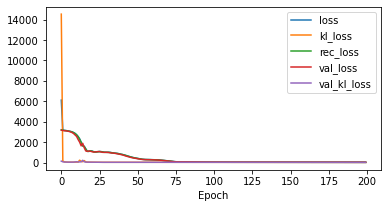

In [79]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

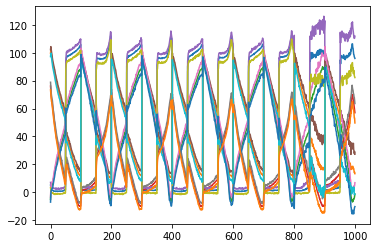

In [80]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

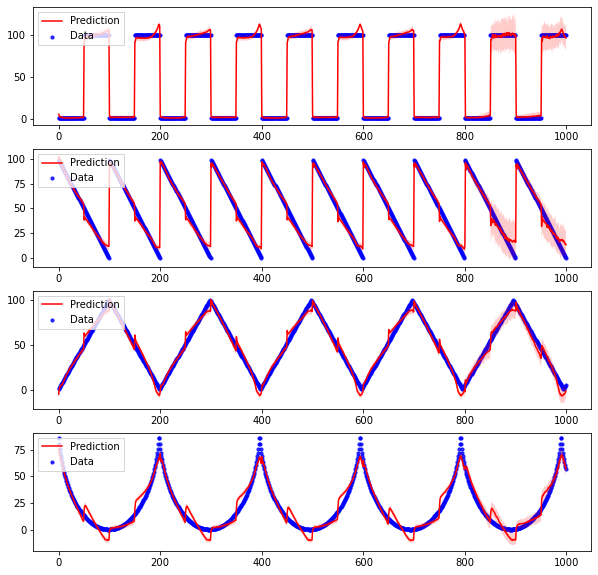

In [81]:
fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [82]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  32.974434   0.962559  3.374494
               MSE  R-squared       MAE
sample1  45.461315   0.981446  2.230901
sample2  31.859379   0.961765  3.216502
sample3  21.515621   0.974142  3.607184
sample4  33.061409   0.932885  4.443388


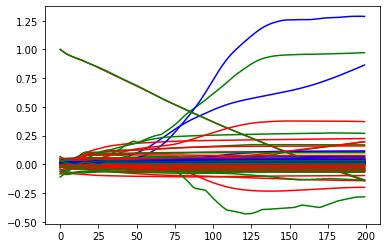

In [83]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
#################################################################################

# Przesuniecie i normalizacja danych

## Trenowanie dla pierwszych 5 treningow po przesunieciu w plaszczyznie longitude x latitude

In [106]:
#5 Workoutow, gdzie zbijamy longitude i latitude w przesuniecie



def translation(i):
    lon = np.asarray(data_endo[i]['longitude'])
    lat = np.asarray(data_endo[i]['latitude'])
    tra = np.sqrt(np.power(lon, 2) + np.power(lat,2))
    return tra

data = np.vstack( [translation(i) for i in range(5)]).T
#print(data.shape)

In [107]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [108]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [109]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

Epoch= 1/200, loss= 140797165568.000, mse= 4160.956, kld= 703985811456.000
	val_loss= 4271.971, val_mse= 4129.419, val_kld= 712.758
Epoch= 11/200, loss= 2776.105, mse= 2768.228, kld= 39.387
	val_loss= 2384.907, val_mse= 2376.591, val_kld= 41.581
Epoch= 21/200, loss= 962.078, mse= 954.502, kld= 37.880
	val_loss= 724.822, val_mse= 716.839, val_kld= 39.914
Epoch= 31/200, loss= 406.484, mse= 398.960, kld= 37.621
	val_loss= 384.169, val_mse= 375.953, val_kld= 41.080
Epoch= 41/200, loss= 219.039, mse= 212.142, kld= 34.486
	val_loss= 282.330, val_mse= 274.514, val_kld= 39.078
Epoch= 51/200, loss= 141.682, mse= 135.451, kld= 31.155
	val_loss= 113.614, val_mse= 106.862, val_kld= 33.761
Epoch= 61/200, loss= 74.510, mse= 68.847, kld= 28.317
	val_loss= 79.173, val_mse= 72.741, val_kld= 32.162
Epoch= 71/200, loss= 61.444, mse= 56.144, kld= 26.499
	val_loss= 59.801, val_mse= 53.687, val_kld= 30.570
Epoch= 81/200, loss= 46.203, mse= 41.145, kld= 25.288
	val_loss= 44.855, val_mse= 39.192, val_kld= 28.

<AxesSubplot:xlabel='Epoch'>

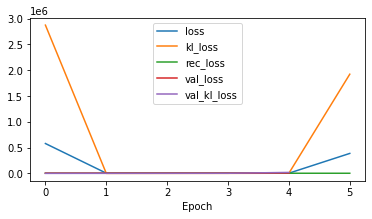

In [88]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

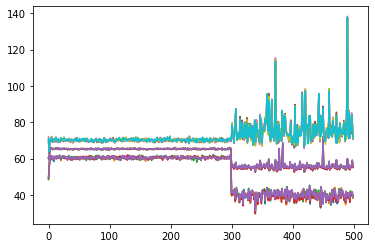

In [110]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

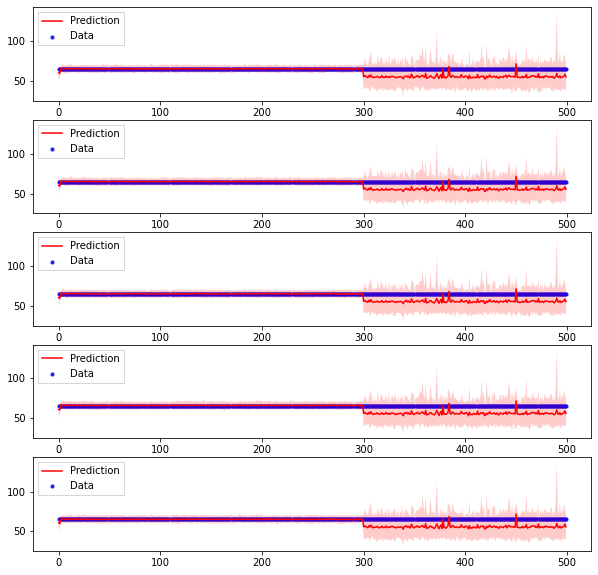

In [111]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [112]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE     R-squared       MAE
Average  36.923252 -50194.284252  3.995948
               MSE     R-squared       MAE
sample1  38.253452 -31364.757568  4.044456
sample2  37.217949 -55978.252240  4.001642
sample3  35.177475 -26092.323091  3.924832
sample4  38.462711 -59397.750429  4.093288
sample5  35.504665 -78138.337931  3.915524


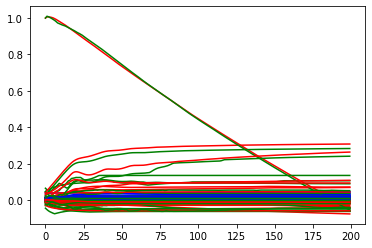

In [113]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [114]:
##########################################################################################################

## Trenowane dla znormalizowanych latitude i longitude

In [115]:
#Normalizacja dla 2D - latitude i longitude


def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
#norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat]).T
#print(data.shape)


In [116]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [117]:
dkf = DKF(input_dim=2, z_dim=10, rnn_dim=10, trans_dim=10, emission_dim=10)

In [118]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 3118.313, mse= 2900.149, kld= 2181.634
	val_loss= 2433.552, val_mse= 2410.444, val_kld= 231.078
Epoch= 11/200, loss= 2375.828, mse= 2370.026, kld= 58.024
	val_loss= 2133.090, val_mse= 2127.643, val_kld= 54.472
Epoch= 21/200, loss= 741.790, mse= 736.640, kld= 51.499
	val_loss= 1397.663, val_mse= 1395.062, val_kld= 26.011
Epoch= 31/200, loss= 499.875, mse= 498.668, kld= 12.074
	val_loss= 870.232, val_mse= 868.908, val_kld= 13.237
Epoch= 41/200, loss= 471.822, mse= 470.358, kld= 14.644
	val_loss= 990.632, val_mse= 989.151, val_kld= 14.807
Epoch= 51/200, loss= 463.410, mse= 462.054, kld= 13.556
	val_loss= 1149.186, val_mse= 1147.773, val_kld= 14.126
Epoch= 61/200, loss= 444.632, mse= 443.428, kld= 12.042
	val_loss= 1066.610, val_mse= 1065.274, val_kld= 13.366
Epoch= 71/200, loss= 420.887, mse= 419.742, kld= 11.455
	val_loss= 979.144, val_mse= 977.626, val_kld= 15.172
Epoch= 81/200, loss= 353.634, mse= 352.455, kld= 11.789
	val_loss= 763.583, val_mse= 761.679, val_kld= 1

<AxesSubplot:xlabel='Epoch'>

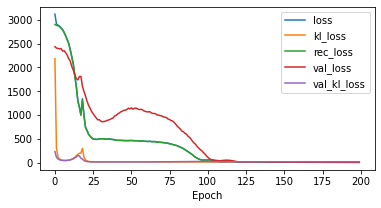

In [119]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

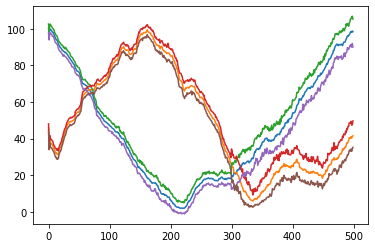

In [120]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

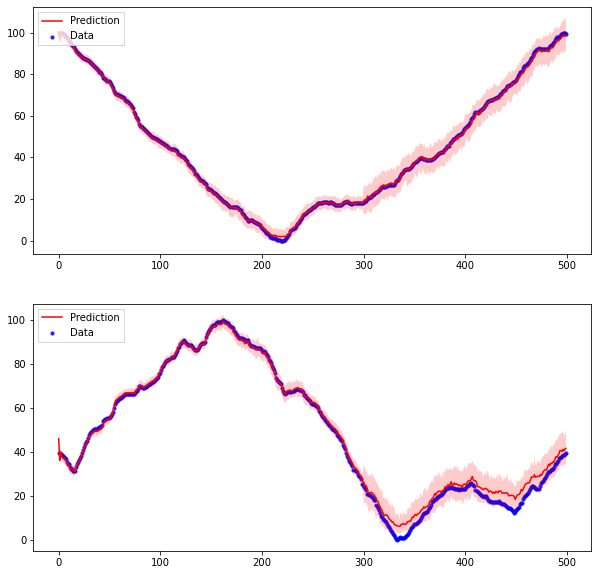

In [121]:
fig, ax = plt.subplots(2, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [122]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared      MAE
Average  3.458408   0.996028  1.16509
              MSE  R-squared       MAE
sample1  0.630599   0.999268  0.571248
sample2  6.286216   0.992789  1.758933


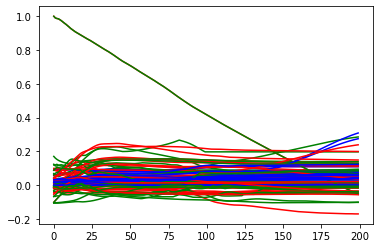

In [123]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
#Normalizacja dla 3D - latitude, longitude i altitude

## Trenowanie dla znormalizowanych danych latitude, longitude, altitude

In [124]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))

norm_long = NormalizeData(np.asarray(data_endo[0]['longitude']))
norm_lat  = NormalizeData(np.asarray(data_endo[0]['latitude']))
norm_alt  = NormalizeData(np.asarray(data_endo[0]['altitude']))

data = np.vstack([norm_long, norm_lat, norm_alt]).T
#print(data.shape)


In [125]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [126]:
dkf = DKF(input_dim=3, z_dim=15, rnn_dim=15, trans_dim=15, emission_dim=15)

In [127]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 87677.336, mse= 3092.386, kld= 563899.688
	val_loss= 2041.264, val_mse= 2036.486, val_kld= 31.857
Epoch= 11/200, loss= 2368.847, mse= 2282.979, kld= 572.456
	val_loss= 1760.165, val_mse= 1755.875, val_kld= 28.599
Epoch= 21/200, loss= 759.383, mse= 741.362, kld= 120.144
	val_loss= 895.907, val_mse= 891.244, val_kld= 31.086
Epoch= 31/200, loss= 469.447, mse= 463.744, kld= 38.022
	val_loss= 845.622, val_mse= 841.735, val_kld= 25.917
Epoch= 41/200, loss= 424.478, mse= 419.286, kld= 34.615
	val_loss= 788.721, val_mse= 784.971, val_kld= 25.001
Epoch= 51/200, loss= 376.399, mse= 371.592, kld= 32.047
	val_loss= 750.642, val_mse= 747.125, val_kld= 23.442
Epoch= 61/200, loss= 273.757, mse= 269.003, kld= 31.690
	val_loss= 536.563, val_mse= 532.775, val_kld= 25.249
Epoch= 71/200, loss= 124.908, mse= 119.888, kld= 33.467
	val_loss= 210.081, val_mse= 205.379, val_kld= 31.349
Epoch= 81/200, loss= 104.887, mse= 100.054, kld= 32.221
	val_loss= 109.089, val_mse= 104.316, val_kld= 31.

<AxesSubplot:xlabel='Epoch'>

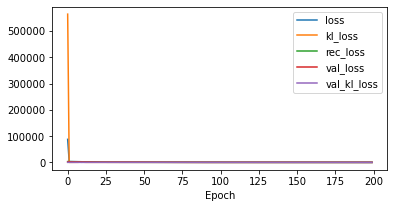

In [128]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

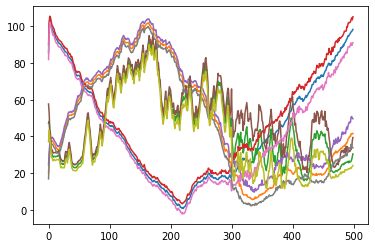

In [129]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

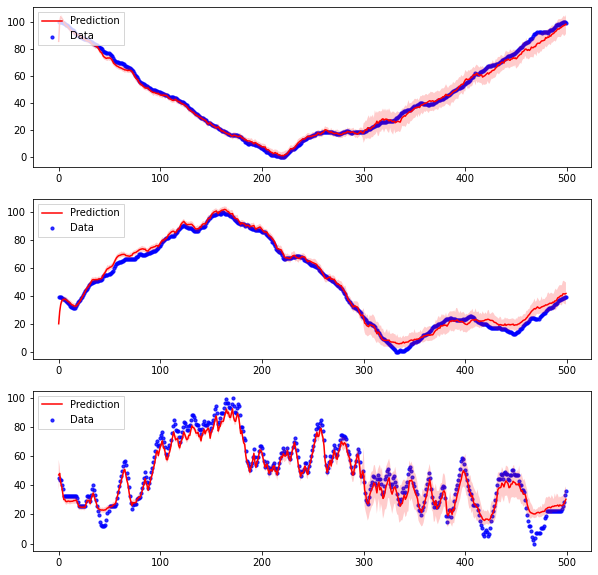

In [130]:
fig, ax = plt.subplots(3, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [131]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared      MAE
Average  14.512703   0.975705  2.82244
               MSE  R-squared       MAE
sample1   6.263494   0.992725  1.794515
sample2   9.025548   0.989646  2.357442
sample3  28.249067   0.944744  4.315363


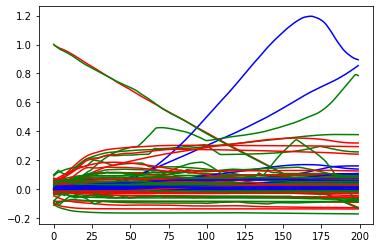

In [132]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

In [ ]:
############################################################################################################

In [ ]:
#5 Workoutow ze znormalizowanym altitude

## 5 treningow z znormalizowanym altitude

In [34]:
def NormalizeData(data):
    return 100*(data - np.min(data)) / (np.max(data) - np.min(data))


data = np.vstack([NormalizeData(np.asarray(data_endo[i]['altitude'])) for i in range(5)]).T
print(data.shape)

print(data)

(500, 5)
[[45.30201342 41.8972332  70.95709571 31.39534884 79.28571429]
 [43.62416107 43.08300395 65.67656766 32.94573643 79.28571429]
 [43.62416107 43.08300395 64.35643564 32.94573643 79.28571429]
 ...
 [28.8590604  33.59683794 27.72277228 33.72093023 16.42857143]
 [33.22147651 35.17786561 32.01320132 35.65891473 18.57142857]
 [36.24161074 35.17786561 32.01320132 39.53488372 15.71428571]]


In [175]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [176]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

In [177]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.15)

Epoch= 1/200, loss= 3347.626, mse= 2986.764, kld= 2405.749
	val_loss= 801.293, val_mse= 796.716, val_kld= 30.512
Epoch= 11/200, loss= 991.998, mse= 934.937, kld= 380.408
	val_loss= 147.990, val_mse= 145.149, val_kld= 18.936
Epoch= 21/200, loss= 431.285, mse= 426.682, kld= 30.683
	val_loss= 177.697, val_mse= 174.658, val_kld= 20.256
Epoch= 31/200, loss= 386.801, mse= 382.360, kld= 29.608
	val_loss= 187.265, val_mse= 184.507, val_kld= 18.381
Epoch= 41/200, loss= 368.403, mse= 364.418, kld= 26.561
	val_loss= 140.761, val_mse= 138.468, val_kld= 15.286
Epoch= 51/200, loss= 354.228, mse= 350.664, kld= 23.764
	val_loss= 133.770, val_mse= 131.646, val_kld= 14.161
Epoch= 61/200, loss= 329.328, mse= 326.084, kld= 21.628
	val_loss= 119.308, val_mse= 117.353, val_kld= 13.033
Epoch= 71/200, loss= 288.281, mse= 285.122, kld= 21.059
	val_loss= 109.773, val_mse= 107.890, val_kld= 12.548
Epoch= 81/200, loss= 252.804, mse= 249.694, kld= 20.732
	val_loss= 107.644, val_mse= 105.698, val_kld= 12.978
Epoch=

<AxesSubplot:xlabel='Epoch'>

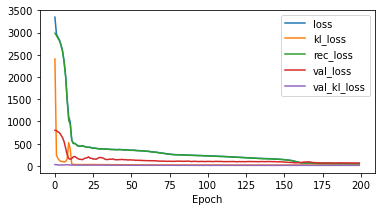

In [178]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

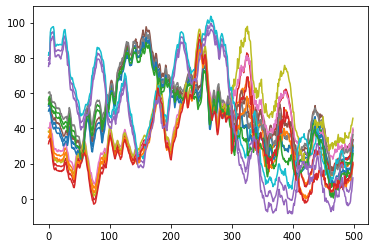

In [179]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

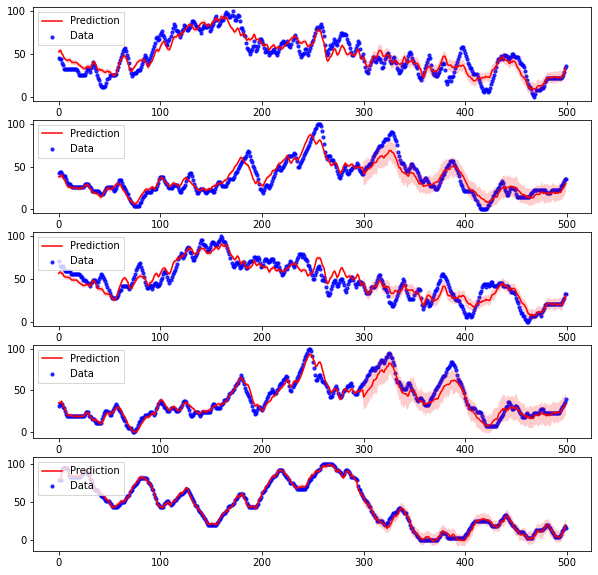

In [180]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [181]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE  R-squared       MAE
Average  52.47303   0.890493  5.317832
               MSE  R-squared       MAE
sample1  79.457825   0.844578  7.286608
sample2  55.667458   0.867615  5.790020
sample3  74.255318   0.843911  6.940994
sample4  48.043316   0.901872  4.946120
sample5   4.941264   0.994488  1.625420


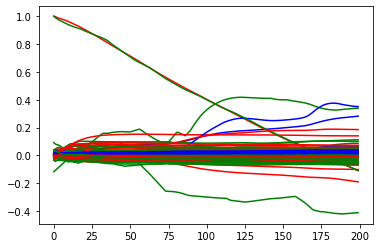

In [182]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Syntetyczne zaszumione

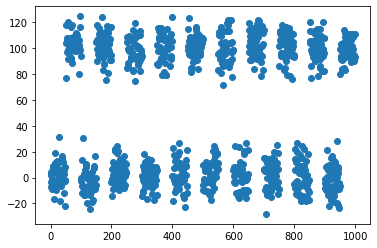

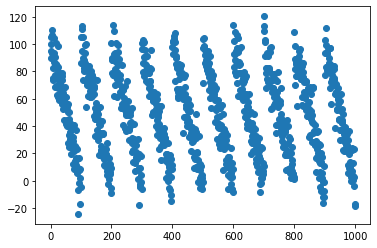

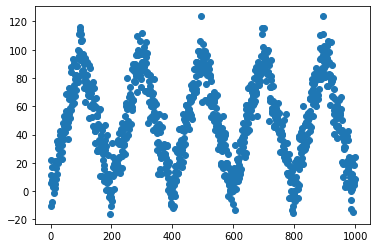

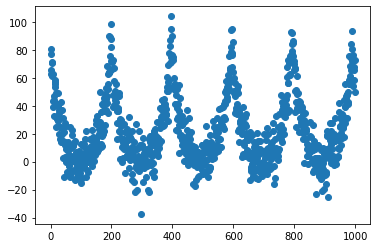

In [184]:
#Dataset 1 - binary a bunch of 1's then a bunch of 100's
data_bin = []
while len(data_bin)<1000:
    data_bin.extend([1 for i in range(50)])
    data_bin.extend([100 for i in range(50)])
data_bin = np.asarray(data_bin[:1000]) 
data_bin =  data_bin + np.random.normal(0, 10, size = data_bin.shape)
#print(data_bin)
plt.scatter(range(len(data_bin)),data_bin)
plt.show()



#Dataset 2 - Decreasing from 100 to 1 in a loop
data_spike = []
while len(data_spike)<1000:
    data_spike.extend([-i + 100 for i in range(1, 101)])
    
data_spike = np.asarray(data_spike[:1000])
data_spike = data_spike + np.random.normal(0,10, size = data_spike.shape)
#print(data_spike)
plt.scatter(range(len(data_spike)), data_spike)
plt.show()

#Dataset 3 - Growing from 1 to 100 then from 100 to 1

data_alt = []
while len(data_alt)<1000:
    data_alt.extend([i for i in range(1,100)])
    data_alt.extend([i for i in range(100,0,-1)])
    
data_alt = np.asarray(data_alt[:1000])
data_alt = data_alt + np.random.normal(0, 10, size = data_alt.shape)
#print(data_alt)
plt.scatter(range(len(data_alt)), data_alt)
plt.show()

#Dataset 4 - Lower half of a circle
data_circle = []
while len(data_circle)<1000:
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(99,0,-1)])
    data_circle.extend([-np.sqrt(100 ** 2 - i ** 2) + 100 for i in range(1,100)])
    
data_circle = np.asarray(data_circle[:1000])
data_circle = data_circle + np.random.normal(0, 10, size = data_circle.shape)
#print(data_circle)
#print(len(data_circle))
plt.scatter(range(len(data_circle)), data_circle)
plt.show()

data = np.vstack([data_bin, data_spike, data_alt, data_circle]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:600]).reshape(1, 600, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[600:800]).reshape(1, 200, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= 3358.918, mse= 3261.203, kld= 488.577
	val_loss= 3324.580, val_mse= 3309.372, val_kld= 76.041
Epoch= 11/200, loss= 2128.861, mse= 2118.391, kld= 52.348
	val_loss= 3049.993, val_mse= 1922.624, val_kld= 5636.846
Epoch= 21/200, loss= 1212.808, mse= 1208.558, kld= 21.250
	val_loss= 1205.182, val_mse= 1200.690, val_kld= 22.462
Epoch= 31/200, loss= 1027.736, mse= 1022.277, kld= 27.296
	val_loss= 990.144, val_mse= 984.481, val_kld= 28.313
Epoch= 41/200, loss= 515.483, mse= 507.947, kld= 37.679
	val_loss= 481.153, val_mse= 473.476, val_kld= 38.383
Epoch= 51/200, loss= 455.142, mse= 449.009, kld= 30.667
	val_loss= 459.377, val_mse= 453.078, val_kld= 31.494
Epoch= 61/200, loss= 414.783, mse= 409.226, kld= 27.784
	val_loss= 413.904, val_mse= 408.089, val_kld= 29.076
Epoch= 71/200, loss= 392.678, mse= 387.493, kld= 25.924
	val_loss= 394.038, val_mse= 388.589, val_kld= 27.243
Epoch= 81/200, loss= 369.300, mse= 364.314, kld= 24.930
	val_loss= 370.474, val_mse= 365.223, val_kld= 2

<AxesSubplot:xlabel='Epoch'>

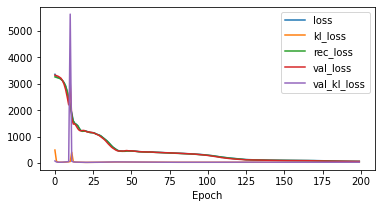

In [185]:
## Trenowanie dla danych syntetycznych

dkf = DKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')



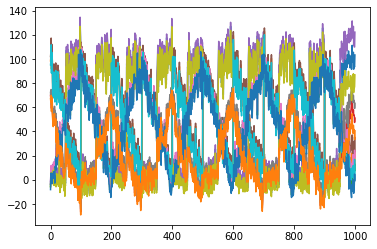

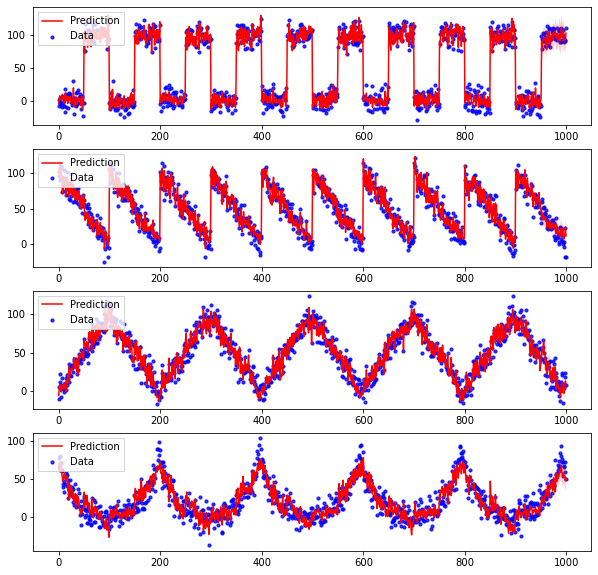

In [186]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(4, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

#################################################################################

In [187]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  58.825966   0.930293  5.803561
               MSE  R-squared       MAE
sample1  47.724049   0.981400  5.077359
sample2  39.494244   0.958096  4.787816
sample3  49.627068   0.946506  5.516902
sample4  98.458488   0.835168  7.832165


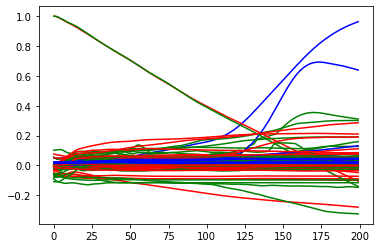

In [188]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Haversine distance

In [40]:

def workout_to_haversine(i):
    ###Calculates haversine distance from point [0,0] in radians for a workout
    ###sklearn wants [lat,long] in radians
    ### to get distance in kilometers multiply by 6371000/1000 
    lat = np.asarray(data_endo[i]['latitude'])
    lon = np.asarray(data_endo[i]['longitude'])
    coords = np.column_stack([lat, lon])    
    coords_in_radians = np.radians(coords)
    zeros = np.zeros_like(coords_in_radians)
    zeros = np.radians(zeros)
    result = haversine_distances(coords_in_radians, zeros)
    result = result
    return result[:,0]


In [190]:

data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 4.410, mse= 3.580, kld= 4.151
	val_loss= 4.179, val_mse= 3.582, val_kld= 2.989
Epoch= 11/200, loss= 2.700, mse= 2.594, kld= 0.527
	val_loss= 2.392, val_mse= 2.286, val_kld= 0.530
Epoch= 21/200, loss= 2.282, mse= 2.239, kld= 0.215
	val_loss= 2.364, val_mse= 2.326, val_kld= 0.190
Epoch= 31/200, loss= 2.099, mse= 2.077, kld= 0.111
	val_loss= 2.149, val_mse= 2.131, val_kld= 0.090
Epoch= 41/200, loss= 1.934, mse= 1.923, kld= 0.056
	val_loss= 1.712, val_mse= 1.701, val_kld= 0.054
Epoch= 51/200, loss= 1.785, mse= 1.778, kld= 0.038
	val_loss= 1.602, val_mse= 1.595, val_kld= 0.038
Epoch= 61/200, loss= 1.627, mse= 1.621, kld= 0.028
	val_loss= 1.742, val_mse= 1.737, val_kld= 0.027
Epoch= 71/200, loss= 1.539, mse= 1.534, kld= 0.021
	val_loss= 1.317, val_mse= 1.313, val_kld= 0.020
Epoch= 81/200, loss= 1.317, mse= 1.313, kld= 0.016
	val_loss= 1.314, val_mse= 1.310, val_kld= 0.018
Epoch= 91/200, loss= 1.172, mse= 1.169, kld= 0.014
	val_loss= 1.416, val_mse= 1.414, val_kld= 0.012
E

<AxesSubplot:xlabel='Epoch'>

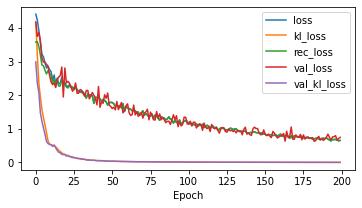

In [191]:
dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

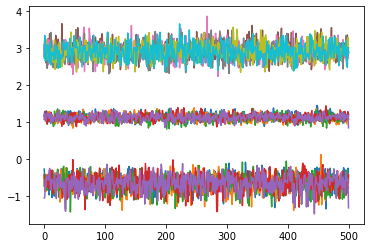

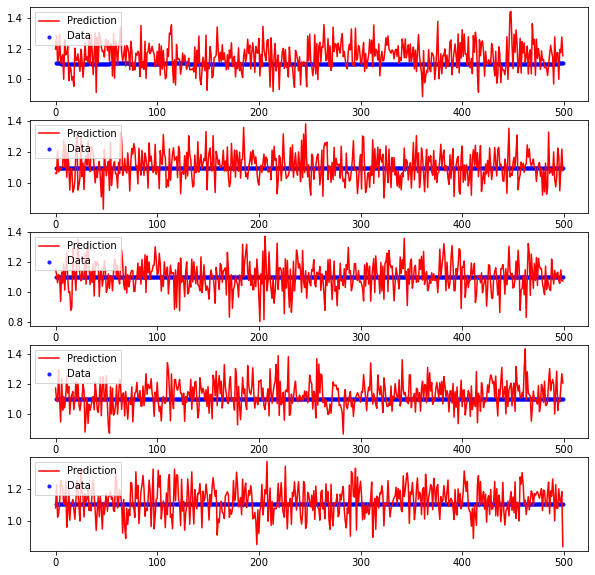

In [192]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [193]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

              MSE     R-squared       MAE
Average  0.009308 -82080.618465  0.076768
              MSE      R-squared       MAE
sample1  0.010646  -48882.357938  0.083021
sample2  0.008887  -88056.408397  0.074963
sample3  0.009471  -39887.838130  0.076926
sample4  0.008676  -87332.849371  0.072662
sample5  0.008860 -146243.638488  0.076269


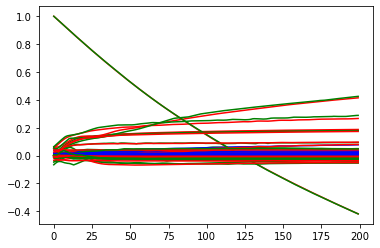

In [194]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Haversine distance normalised to [0,100] for every workout individually

In [245]:
data = np.vstack([NormalizeData(workout_to_haversine(i)) for i in range(5)]).T
#print(data.shape)

#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)



torch.Size([1, 500, 5])


In [205]:

dkf = DKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)


Epoch= 1/200, loss= 4341.791, mse= 4015.242, kld= 3265.485
	val_loss= 5940.666, val_mse= 5927.291, val_kld= 133.754
Epoch= 11/200, loss= 952.064, mse= 933.328, kld= 187.358
	val_loss= 933.971, val_mse= 918.533, val_kld= 154.382
Epoch= 21/200, loss= 728.192, mse= 724.038, kld= 41.539
	val_loss= 1349.037, val_mse= 1342.718, val_kld= 63.187
Epoch= 31/200, loss= 630.910, mse= 627.854, kld= 30.563
	val_loss= 881.972, val_mse= 876.903, val_kld= 50.699
Epoch= 41/200, loss= 617.695, mse= 614.995, kld= 27.001
	val_loss= 789.770, val_mse= 785.281, val_kld= 44.891
Epoch= 51/200, loss= 594.160, mse= 591.818, kld= 23.420
	val_loss= 772.171, val_mse= 768.216, val_kld= 39.550
Epoch= 61/200, loss= 558.315, mse= 556.170, kld= 21.455
	val_loss= 724.781, val_mse= 720.992, val_kld= 37.890
Epoch= 71/200, loss= 457.846, mse= 455.669, kld= 21.768
	val_loss= 445.924, val_mse= 441.326, val_kld= 45.987
Epoch= 81/200, loss= 220.282, mse= 217.622, kld= 26.602
	val_loss= 177.014, val_mse= 171.206, val_kld= 58.075


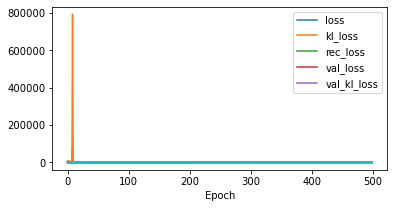

In [206]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)



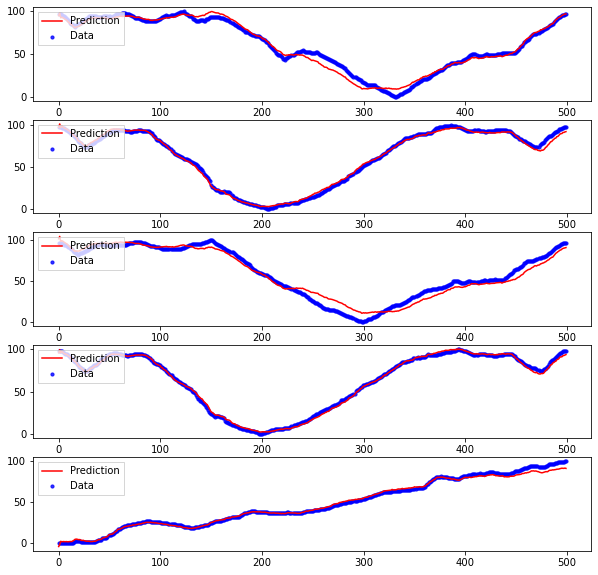

In [207]:
fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [208]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

               MSE  R-squared       MAE
Average  16.235273   0.982902  2.855905
               MSE  R-squared       MAE
sample1  20.209558   0.977223  3.442127
sample2   6.668675   0.994012  1.863886
sample3  43.467014   0.954985  5.587907
sample4   4.119992   0.996258  1.603808
sample5   6.711132   0.992033  1.781795


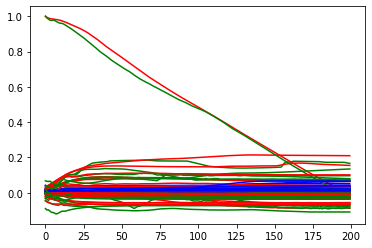

In [209]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

## Wodociągi Wrocławskie

In [210]:
#i = #examples
i = 7

In [211]:
df = pd.read_csv('water_consumption_profiles.csv')

In [212]:
_ = df.values

In [213]:
all_days = _[:,1:].T

In [214]:
all_days.shape

(144, 651)

In [215]:
all_days = all_days.astype('float64')

In [216]:
data = all_days[:, :7]

In [218]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:100]).reshape(1, 100, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[100:120]).reshape(1, 20, data.shape[1])
#print(x_val)



Epoch= 1/200, loss= 866.290, mse= 838.205, kld= 280.848
	val_loss= 1067.229, val_mse= 1064.338, val_kld= 28.914
Epoch= 11/200, loss= 169.325, mse= 166.233, kld= 30.924
	val_loss= 264.226, val_mse= 260.014, val_kld= 42.115
Epoch= 21/200, loss= 52.611, mse= 49.608, kld= 30.027
	val_loss= 38.759, val_mse= 34.283, val_kld= 44.754
Epoch= 31/200, loss= 68.499, mse= 66.442, kld= 20.570
	val_loss= 31.467, val_mse= 27.531, val_kld= 39.357
Epoch= 41/200, loss= 43.023, mse= 41.429, kld= 15.941
	val_loss= 24.426, val_mse= 21.040, val_kld= 33.862
Epoch= 51/200, loss= 40.943, mse= 39.734, kld= 12.093
	val_loss= 20.330, val_mse= 17.446, val_kld= 28.846
Epoch= 61/200, loss= 39.408, mse= 38.503, kld= 9.052
	val_loss= 15.674, val_mse= 13.235, val_kld= 24.386
Epoch= 71/200, loss= 38.137, mse= 37.384, kld= 7.524
	val_loss= 18.149, val_mse= 15.790, val_kld= 23.586
Epoch= 81/200, loss= 38.415, mse= 37.698, kld= 7.176
	val_loss= 18.241, val_mse= 15.868, val_kld= 23.732
Epoch= 91/200, loss= 36.414, mse= 35.77

<AxesSubplot:xlabel='Epoch'>

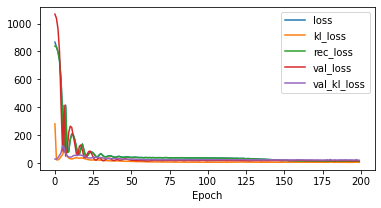

In [219]:

dkf = DKF(input_dim=i, z_dim=5*i, rnn_dim=5*i, trans_dim=5*i, emission_dim=5*i)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

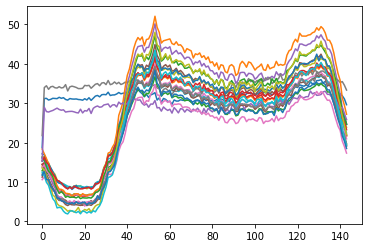

In [220]:

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


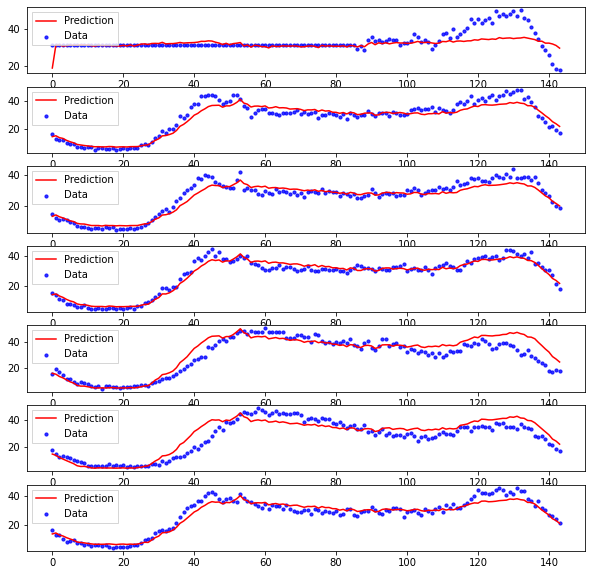

In [221]:
fig, ax = plt.subplots(i, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [222]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


               MSE  R-squared       MAE
Average  19.357325   0.790829  3.219648
               MSE  R-squared       MAE
sample1  24.555601   0.229642  2.820086
sample2  16.833191   0.893629  3.302457
sample3  11.808977   0.899602  2.704458
sample4   6.952225   0.950004  2.153428
sample5  34.176804   0.823544  4.388855
sample6  30.510963   0.818955  4.627341
sample7  10.663501   0.920427  2.540912


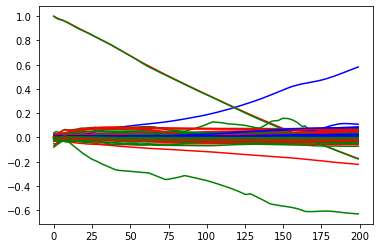

In [223]:

for i, _ in enumerate(range(3 * len(param_dict.keys()))):

    #print(i)
    if i % 3 == 0:
        stat = "Mean"
        colour = 'r'
    elif i % 3 == 1:
        stat = "Variance"
        colour = 'b'
    else:
        stat = "Median"
        colour = 'g'

    plt.plot(np.array(param_dict['mean_var_median' + str(i % 32)])[:, i % 3], label = stat, c = colour)



plt.show()

# Sample-Normalized Deep Kalman Filter

In [26]:
def NormalizeByRow(data):
    
    data = data.numpy()
    
    # Reshape the data into a 2-dimensional array (500 rows, 5 columns)
    reshaped_data = data.reshape(data.shape[1], data.shape[2])

    # Calculate the minimum and maximum values for each column
    min_values = np.min(reshaped_data, axis=0)
    max_values = np.max(reshaped_data, axis=0)

    # Normalize each column to the range 0 to 100
    normalized_data = ((reshaped_data - min_values) / (max_values - min_values)) * 100

    # Reshape the normalized data back to the original shape
    normalized_data = normalized_data.reshape(1, data.shape[1], data.shape[2])
    normalized_data = torch.FloatTensor(normalized_data)

    return(normalized_data)

def DenormalizeByRow(normalized_data, original_min, original_max):
    # Convert the PyTorch tensor to a NumPy array
    normalized_data = normalized_data.numpy()
    
    # Reshape the normalized data into a 2-dimensional array (number_of_samples, number_of_features)
    reshaped_data = normalized_data.reshape(normalized_data.shape[1], normalized_data.shape[2])

    # Calculate the denormalized data using the original range
    denormalized_data = original_min + (reshaped_data / 100) * (original_max - original_min)

    # Reshape the denormalized data back to the original shape
    denormalized_data = denormalized_data.reshape(1, normalized_data.shape[1], normalized_data.shape[2])
    
    # Convert the denormalized NumPy array back to a PyTorch tensor
    denormalized_data = torch.FloatTensor(denormalized_data)

    return denormalized_data



#max_values, _ = torch.max(matrix, dim=1)
#min_values, _ = torch.min(matrix, dim=1)

#max_values = max_values.numpy()
#min_values = min_values.numpy()

In [27]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T

x = torch.FloatTensor(data).reshape(1, *data.shape)

print(x)

y = NormalizeByRow(x)

print(y)
y = y.numpy()
print(np.max(y, axis = 1))
print(np.min(y, axis = 1))

tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [31.8000, 34.2000, 50.2000, 29.8000, 14.4000],
         [34.4000, 35.0000, 52.8000, 30.8000, 15.0000],
         [36.2000, 35.0000, 52.8000, 32.8000, 14.2000]]])
tensor([[[45.3020, 41.8972, 70.9571, 31.3954, 79.2857],
         [43.6242, 43.0830, 65.6766, 32.9457, 79.2857],
         [43.6242, 43.0830, 64.3564, 32.9457, 79.2857],
         ...,
         [28.8591, 33.5968, 27.7228, 33.7209, 16.4286],
         [33.2215, 35.1779, 32.0132, 35.6589, 18.5714],
         [36.2416, 35.1779, 32.0132, 39.5349, 15.7143]]])
[[100. 100. 100. 100. 100.]]
[[0. 0. 0. 0. 0.]]


In [35]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, hid_dim):
        super(GatedTransition, self).__init__()
        self.gate = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim),
            nn.Sigmoid())
        self.proposed_mean = nn.Sequential(nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, z_dim))
        self.z_to_mu = nn.Linear(z_dim, z_dim)
        # modify the default initialization of z_to_mu
        # so that it starts out as the identity function
        self.z_to_mu.weight.data = torch.eye(z_dim)
        self.z_to_mu.bias.data = torch.zeros(z_dim)
        self.z_to_logvar = nn.Linear(z_dim, z_dim)
        self.relu = nn.ReLU()
        
    def forward(self, z_t_1):
        #
        gate = self.gate(z_t_1)
        proposed_mean = self.proposed_mean(z_t_1)
        mu = (1 - gate) * self.z_to_mu(z_t_1) + gate * proposed_mean
        logvar = self.z_to_logvar(self.relu(proposed_mean))
        # sampling
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [36]:
class Combiner(nn.Module):
    # PostNet
    def __init__(self, z_dim, hid_dim):
        super(Combiner, self).__init__()
        self.z_dim = z_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_mu = nn.Linear(hid_dim, z_dim)
        self.hidden_to_logvar = nn.Linear(hid_dim, z_dim)
        self.tanh = nn.Tanh()
    def forward(self, z_t_1, h_rnn):
        # combine the rnn hidden state with a transformed version of z_t_1
        h_combined = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        # use the combined hidden state
        # to compute the mean used to sample z_t
        mu = self.hidden_to_mu(h_combined)
        # use the combined hidden state
        # to compute the scale used to sample z_t
        logvar = self.hidden_to_logvar(h_combined)
        eps = torch.randn(z_t_1.size())
        z_t = mu + eps * torch.exp(.5 * logvar)
        return z_t, mu, logvar

In [37]:
class Emitter(nn.Module):
    def __init__(self, z_dim, hid_dim, input_dim) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.z_to_hidden = nn.Linear(z_dim, hid_dim)
        self.hidden_to_hidden = nn.Linear(hid_dim, hid_dim)
        self.hidden_to_input_mu = nn.Linear(hid_dim, input_dim)
        self.logvar = nn.Parameter(torch.ones(input_dim))
        self.relu = nn.ReLU()
    def forward(self, z_t):
        h1 = self.relu(self.z_to_hidden(z_t))
        h2 = self.relu(self.hidden_to_hidden(h1))
        mu = self.hidden_to_input_mu(h2)
        # return mu # x_t
        eps = torch.randn(z_t.size(0), self.input_dim)
        x_t = mu + eps * torch.exp(.5 * self.logvar)
        return x_t, mu, self.logvar

In [107]:
class RNDKF(nn.Module):
    # Structured Inference Networks
    # Current version ignores backward RNN outputs
    def __init__(self, input_dim, z_dim=50, trans_dim=30, emission_dim=30,
            rnn_dim=100, num_rnn_layers=1) -> None:
        
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        self.trans_dim = trans_dim
        self.emission_dim = emission_dim
        self.rnn_dim = rnn_dim
        self.num_rnn_layers = num_rnn_layers
        self.trans = GatedTransition(z_dim, trans_dim)
        self.emitter = Emitter(z_dim, emission_dim, input_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.z_0 = nn.Parameter(torch.zeros(z_dim))
        self.z_q_0 = nn.Parameter(torch.zeros(z_dim))
        self.h_0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        # corresponding learning 'l' in the original code
        self.rnn = nn.RNN(input_size=input_dim,
            hidden_size=rnn_dim,
            nonlinearity="relu",
            batch_first=True,
            bidirectional=False,
            num_layers=num_rnn_layers)
        
    def kl_div(self, mu1, logvar1, mu2=None, logvar2=None):
        if mu2 is None:
            mu2 = torch.zeros(1, device=mu1.device)
        if logvar2 is None:
            logvar2 = torch.zeros(1, device=mu1.device)
        return torch.sum(0.5 * (
            logvar2 - logvar1 + (torch.exp(logvar1) + (mu1 - mu2).pow(2))
            / torch.exp(logvar2) - torch.ones(1, device=mu1.device)
        ), 1)

    def infer(self, x):
        batch_size, T_max, x_dim = x.size()
        h_0 = self.h_0.expand(1, batch_size, self.rnn_dim).contiguous()
        rnn_out, h_n = self.rnn(x, h_0)
        z_prev = self.z_q_0.expand(batch_size, self.z_q_0.size(0))
        kl_states = torch.zeros((batch_size, T_max))
        rec_losses = torch.zeros((batch_size, T_max))
        for t in range(T_max):
            # p(z_t|z_{t-1})
            z_prior, z_prior_mu, z_prior_logvar = self.trans(z_prev)
            # q(z_t|z_{t-1},x_{t:T})
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            # p(x_t|z_t)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # compute loss
            kl_states[:, t] = self.kl_div(
                z_mu, z_logvar, z_prior_mu, z_prior_logvar)
            rec_losses[:, t] = nn.MSELoss(reduction='none')(
                x_t.contiguous().view(-1),
                # x_mu.contiguous().view(-1),
                x[:, t].contiguous().view(-1)
            ).view(batch_size, -1).mean(dim=1)
            z_prev = z_t
        return rec_losses.mean(), kl_states.mean()
    
    def filter(self, x, num_sample=100):
        # Outputs
        x_hat = torch.zeros(x.size())
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        # predictions
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x, h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            # x_hat[:, t] = x_mu
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            # # sampling z_t and computing quantiles
            # x_samples = MultivariateNormal(
            #   loc=x_mu, covariance_matrix=x_covar).sample_n(num_sample)
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            # x_hat[:, t] = x_t.mean(0)
            # x_025[:, t] = x_t.quantile(0.025, 0)
            # x_975[:, t] = x_t.quantile(0.975, 0)
            z_prev = z_t
            # z_prev = z_mu
        return x_hat, x_025, x_975
    
    def predict(self, x, pred_steps=1, num_sample=100):
        """ x should contain the prediction period
        """
        # Outputs
                    
        max_x, _ = torch.max(x, dim=1)
        min_x, _ = torch.min(x, dim=1)
        
        max_x = max_x.numpy()
        min_x = min_x.numpy()
        
        print(max_x)
        print(min_x)
        
        x = NormalizeByRow(x)
        
        x_hat = torch.zeros(x.size()) # predictions
        x_025 = torch.zeros(x.size())
        x_975 = torch.zeros(x.size())
        batch_size, T_max, x_dim = x.size()
        assert batch_size == 1
        z_prev = self.z_0.expand(num_sample, self.z_0.size(0))
        h_0 = self.h_0.expand(1, 1, self.rnn_dim).contiguous()
        rnn_out, _ = self.rnn(x[:, :T_max-pred_steps], h_0)
        rnn_out = rnn_out.expand(num_sample,
            rnn_out.size(1), rnn_out.size(2))
        for t in range(T_max - pred_steps):
            # z_t: (num_sample, z_dim)
            z_t, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, t])
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            z_prev = z_mu
        for t in range(T_max - pred_steps, T_max):
            rnn_out, _ = self.rnn(x[:, :t], h_0)
            rnn_out = rnn_out.expand(
                num_sample, rnn_out.size(1), rnn_out.size(2))
            z_t_1, z_mu, z_logvar = self.combiner(z_prev, rnn_out[:, -1])
            z_t, z_mu, z_logvar = self.trans(z_t_1)
            x_t, x_mu, x_logvar = self.emitter(z_t)
            x_covar = torch.diag(torch.sqrt(torch.exp(.5 * x_logvar)))
            x_samples = MultivariateNormal(
                x_mu, covariance_matrix=x_covar).sample()
            x_hat[:, t] = x_samples.mean(0)
            x_025[:, t] = x_samples.quantile(0.025, 0)
            x_975[:, t] = x_samples.quantile(0.975, 0)
            
        
        x_hat = DenormalizeByRow(x_hat, min_x, max_x)
        
        x_025 = DenormalizeByRow(x_025, min_x, max_x)
        
        x_975 = DenormalizeByRow(x_975, min_x, max_x)
            
            
        return x_hat, x_025, x_975
    
    def train_step(self, x, annealing_factor = 0.1):
        self.train()
        # self.rnn.train()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        self.optimizer.zero_grad()
        total_loss.backward()
        # nn.utils.clip_grad_norm_(self.parameters(), 5.)
        self.optimizer.step()
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def validation_step(self, x, annealing_factor=0.1):
        self.eval()
        rec_loss, kl_loss = self.infer(x)
        total_loss = rec_loss + annealing_factor * kl_loss
        return rec_loss.item(), kl_loss.item(), total_loss.item()
    
    def fit(self, x, x_val=None, num_epochs=100, annealing_factor=0.1,
            verbose_step=1, eval_step=1, check_point_path=None,
            patience=20, learning_rate=0.01):
        
        #print(x)
        #print(x_val)
        #print(x.shape)
        #print(x_val.shape)
        
        concat_x = torch.cat((x, x_val), dim = 1)
        
        concat_x = NormalizeByRow(concat_x)
        
        x = concat_x[:, :x.shape[1], :]
        x_val = concat_x[:, x.shape[1]:, :]
        
        
        #x = NormalizeByRow(x)
        
        #x_val = NormalizeByRow(x_val)
        
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=learning_rate)
        
        losses = []
        kl_losses = []
        rec_losses = []
        val_losses = []
        val_kl_losses = []
        val_rec_losses = []
        parameter_values = []

        
        stats_dict = {}
        
        for index, param in enumerate(self.parameters()):
            stats_dict['mean_var_median' + str(index)] = []
            
                        
            
        
        
        for epoch in range(num_epochs):
            for index, param in enumerate(self.parameters()):
                param_value = param.detach().numpy()
                stats_dict['mean_var_median' + str(index)].append([np.mean(param_value), np.var(param_value), np.median(param_value)])                      

            try:
                res = self.train_step(x, annealing_factor=annealing_factor)
                losses.append(res[2])
                kl_losses.append(res[1])
                rec_losses.append(res[0])  
                
                if epoch % verbose_step == verbose_step - 1:
                    message = f'Epoch= {epoch+1}/{num_epochs}, '
                    message += f'loss= {res[2]:.3f}, '
                    message += f'mse= {res[0]:.3f}, '
                    message += f'kld= {res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
                if x_val is not None:
                    val_res = self.validation_step(x_val, annealing_factor)
                    val_losses.append(val_res[2])
                    val_kl_losses.append(val_res[1])
                    val_rec_losses.append(val_res[0])  
                    
                if epoch % eval_step == eval_step - 1 and x_val is not None:
                    message = f'\tval_loss= {val_res[2]:.3f}, '
                    message += f'val_mse= {val_res[0]:.3f}, '
                    message += f'val_kld= {val_res[1]:.3f}'
                    if (epoch % 10 == 0):
                        print(message)
                    
            except KeyboardInterrupt:
                break                    
                
        history = {'loss': losses,
                   'kl_loss': kl_losses,
                   'rec_loss': rec_losses}
        
        if x_val is not None:
            history.update({'val_loss': val_losses,
                            'val_kl_loss': val_kl_losses,
                            'rec_loss': rec_losses})
            
            
        return history, stats_dict
            
    def save_model(self, filename):
        """ dkf.pth """
        torch.save(self.to('cpu').state_dict(), filename)       
        
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        
    def get_config(self):
        return {
            'input_dim': self.input_dim,
            'z_dim': self.z_dim,
            'trans_dim': self.trans_dim,
            'emission_dim': self.emission_dim,
            'rnn_dim': self.rnn_dim,
            'num_rnn_layers': self.num_rnn_layers
        }

In [108]:
data = np.vstack([NormalizeData(workout_to_haversine(i)) for i in range(5)]).T
#print(data.shape)

#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
print(x.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)




torch.Size([1, 500, 5])


In [109]:
# Create a 4 by 3 numpy array
array = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9],
                  [10, 11, 12]])

# Find the maximum value in each row along axis 1 (rows)
max_values = np.max(array, axis=1)

print(max_values)
x_array = x.numpy()
print(x_array.shape)
print(np.max(x_array, axis = 1))
print(np.min(x_array, axis = 1))
print(list(x_array.shape[i] for i in range(len(x_array.shape))))
print(x_array.shape[0])

[ 3  6  9 12]
(1, 500, 5)
[[100. 100. 100. 100. 100.]]
[[0. 0. 0. 0. 0.]]
[1, 500, 5]
1


In [110]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T

x = torch.FloatTensor(data).reshape(1, *data.shape)

print(x)
x_array = x.numpy()
print(np.max(x_array, axis = 1))
print(np.min(x_array, axis = 1))

tensor([[[41.6000, 38.4000, 76.4000, 28.6000, 32.0000],
         [40.6000, 39.0000, 73.2000, 29.4000, 32.0000],
         [40.6000, 39.0000, 72.4000, 29.4000, 32.0000],
         ...,
         [31.8000, 34.2000, 50.2000, 29.8000, 14.4000],
         [34.4000, 35.0000, 52.8000, 30.8000, 15.0000],
         [36.2000, 35.0000, 52.8000, 32.8000, 14.2000]]])
[[74.2 67.8 94.  64.  37.8]]
[[14.6 17.2 33.4 12.4  9.8]]


In [111]:


# Create a 500 by 5 matrix (replace this with your actual data)
data = np.random.rand(500, 5)

print(data)

# Calculate the minimum and maximum values for each column
min_values = np.min(data, axis=0)
max_values = np.max(data, axis=0)

# Normalize each column to the range 0 to 100
normalized_data = ((data - min_values) / (max_values - min_values)) * 100

print(normalized_data)
print(np.max(normalized_data, axis = 0))
print(np.min(normalized_data, axis = 0))

[[0.02937141 0.3199281  0.30717609 0.81927909 0.64730858]
 [0.01744385 0.95212328 0.34812517 0.09622448 0.57524033]
 [0.22026537 0.71207264 0.58740294 0.77985318 0.40450266]
 ...
 [0.2783928  0.87622178 0.20625131 0.91628575 0.71523824]
 [0.63480962 0.55121823 0.26070642 0.90649128 0.63039886]
 [0.31265185 0.4270349  0.27647695 0.38161852 0.42194087]]
[[ 2.92628137 32.00393912 30.77798499 82.01770601 64.44266323]
 [ 1.73028096 95.96911066 34.89408728  9.57792894 57.14315304]
 [22.0676074  71.68091459 58.94571299 78.06779122 39.84980568]
 ...
 [27.89616278 88.28943762 20.63326926 91.73639222 71.32299139]
 [63.63480125 55.40575129 26.10696582 90.75512602 62.72994448]
 [31.33138691 42.8409485  27.69218169 38.1703486  41.61605357]]
[100. 100. 100. 100. 100.]
[0. 0. 0. 0. 0.]


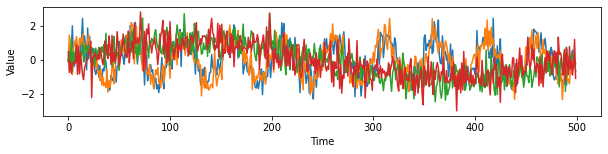

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
# import warnings
# warnings.filterwarnings('ignore')
T = 500 # sequence length
observations = 2*np.sin(np.linspace(0, 20*np.pi, T))
interventions = 2*np.sin(np.linspace(0, 2*np.pi, T))
data = np.vstack([observations, observations*1.2, interventions,
  interventions*0.85]).T
data += np.random.randn(*data.shape)
# data[:, 2:] = preprocessing.minmax_scale(data[:, 2:])
data = scale(data)

plt.figure(figsize=(10, 2))
plt.plot(data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [113]:
x = torch.FloatTensor(data).reshape(1, *data.shape)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)

In [114]:
dkf = RNDKF(input_dim=4, z_dim=20, rnn_dim=20, trans_dim=20, emission_dim=20)

In [115]:
history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

Epoch= 1/200, loss= 2982.884, mse= 2895.622, kld= 872.619
	val_loss= 1956.585, val_mse= 1949.930, val_kld= 66.548
Epoch= 11/200, loss= 2171.065, mse= 665.464, kld= 15056.008
	val_loss= 448.582, val_mse= 445.160, val_kld= 34.221
Epoch= 21/200, loss= 349.184, mse= 346.806, kld= 23.779
	val_loss= 385.330, val_mse= 383.124, val_kld= 22.055
Epoch= 31/200, loss= 282.453, mse= 279.909, kld= 25.441
	val_loss= 328.551, val_mse= 326.063, val_kld= 24.877
Epoch= 41/200, loss= 255.664, mse= 252.620, kld= 30.437
	val_loss= 283.501, val_mse= 280.579, val_kld= 29.222
Epoch= 51/200, loss= 238.405, mse= 235.290, kld= 31.151
	val_loss= 287.336, val_mse= 284.429, val_kld= 29.065
Epoch= 61/200, loss= 226.648, mse= 223.812, kld= 28.357
	val_loss= 266.461, val_mse= 263.669, val_kld= 27.925
Epoch= 71/200, loss= 212.952, mse= 210.332, kld= 26.203
	val_loss= 252.504, val_mse= 249.874, val_kld= 26.300
Epoch= 81/200, loss= 171.735, mse= 169.209, kld= 25.259
	val_loss= 212.300, val_mse= 209.662, val_kld= 26.384
Ep

<AxesSubplot:xlabel='Epoch'>

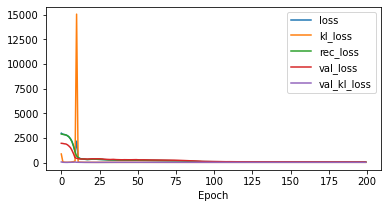

In [116]:
pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

[[2.4821298 2.4622803 2.7782953 2.8465219]]
[[-2.2869356 -2.314187  -2.450089  -2.982882 ]]
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])


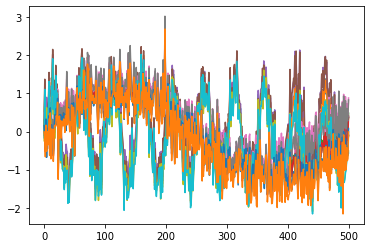

In [117]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

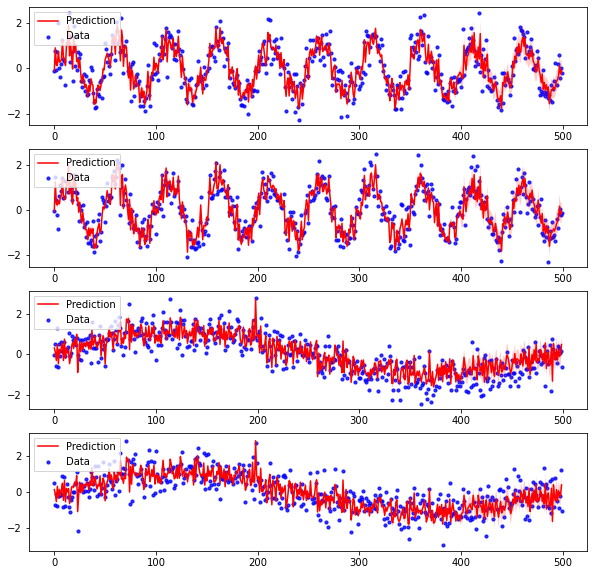

In [118]:
fig, ax = plt.subplots(4, figsize=(10, 10))


#data = NormalizeData(data)

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [119]:

def workout_to_haversine(i):
    ###Calculates haversine distance from point [0,0] in radians for a workout
    ###sklearn wants [lat,long] in radians
    ### to get distance in kilometers multiply by 6371000/1000 
    lat = np.asarray(data_endo[i]['latitude'])
    lon = np.asarray(data_endo[i]['longitude'])
    coords = np.column_stack([lat, lon])    
    coords_in_radians = np.radians(coords)
    zeros = np.zeros_like(coords_in_radians)
    zeros = np.radians(zeros)
    result = haversine_distances(coords_in_radians, zeros)
    result = result
    return result[:,0]


In [120]:

data = np.vstack( [workout_to_haversine(i) for i in range(5)]).T
#print(data.shape)
#print(data)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:400]).reshape(1, 400, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[400:450]).reshape(1, 50, data.shape[1])
#print(x_val)


Epoch= 1/200, loss= 1292074.875, mse= 4113.075, kld= 6439808.500
	val_loss= 6400.106, val_mse= 6343.547, val_kld= 282.795
Epoch= 11/200, loss= 1454.547, mse= 1432.065, kld= 112.410
	val_loss= 1984.734, val_mse= 1956.169, val_kld= 142.823
Epoch= 21/200, loss= 723.164, mse= 715.029, kld= 40.677
	val_loss= 1174.486, val_mse= 1160.802, val_kld= 68.422
Epoch= 31/200, loss= 606.487, mse= 598.788, kld= 38.496
	val_loss= 969.890, val_mse= 959.085, val_kld= 54.024
Epoch= 41/200, loss= 332.519, mse= 325.434, kld= 35.425
	val_loss= 410.197, val_mse= 400.222, val_kld= 49.871
Epoch= 51/200, loss= 260.372, mse= 252.045, kld= 41.631
	val_loss= 294.933, val_mse= 286.271, val_kld= 43.310
Epoch= 61/200, loss= 204.308, mse= 197.862, kld= 32.231
	val_loss= 230.228, val_mse= 221.952, val_kld= 41.378
Epoch= 71/200, loss= 166.639, mse= 160.613, kld= 30.128
	val_loss= 176.418, val_mse= 168.694, val_kld= 38.621
Epoch= 81/200, loss= 119.473, mse= 113.835, kld= 28.192
	val_loss= 157.294, val_mse= 149.619, val_kl

<AxesSubplot:xlabel='Epoch'>

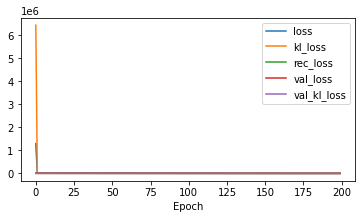

In [122]:
dkf = RNDKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.2)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

[[1.1017815 1.1017488 1.1017824 1.1017468 1.1025736]]
[[1.1002148 1.1007968 1.1002144 1.1007969 1.1017256]]
torch.Size([1, 500, 5])
torch.Size([1, 500, 5])
torch.Size([1, 500, 5])


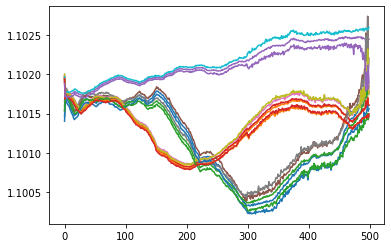

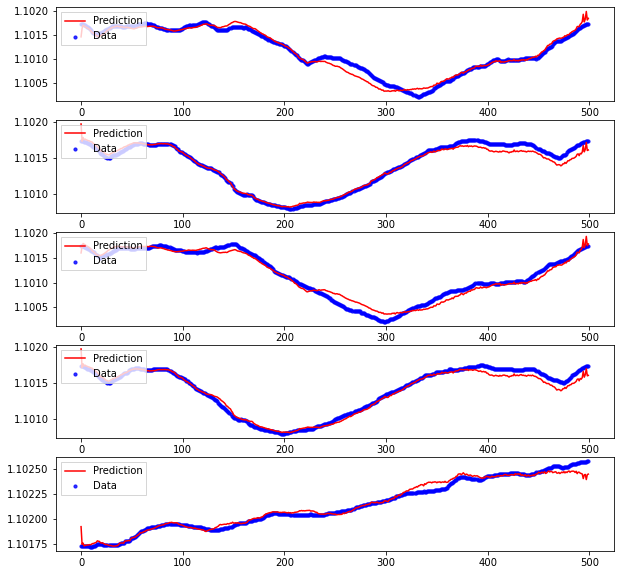

In [123]:
# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)



x_hat, x_025, x_975 = dkf.predict(x, 200)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)



fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()

In [124]:

mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)

                  MSE  R-squared       MAE
Average  4.540451e-09     0.9704  0.000048
                  MSE  R-squared       MAE
sample1  7.188807e-09   0.966992  0.000061
sample2  3.015378e-09   0.970123  0.000038
sample3  8.423161e-09   0.964526  0.000075
sample4  2.735537e-09   0.972464  0.000039
sample5  1.339370e-09   0.977892  0.000025


## Wodociągi SNDKF

Epoch= 1/200, loss= 3126.310, mse= 3072.494, kld= 538.157
	val_loss= 4415.115, val_mse= 4406.664, val_kld= 84.511
Epoch= 11/200, loss= 264.323, mse= 256.522, kld= 78.012
	val_loss= 320.517, val_mse= 305.746, val_kld= 147.710
Epoch= 21/200, loss= 183.960, mse= 176.831, kld= 71.287
	val_loss= 524.254, val_mse= 509.496, val_kld= 147.585
Epoch= 31/200, loss= 118.478, mse= 112.019, kld= 64.598
	val_loss= 237.173, val_mse= 224.677, val_kld= 124.958
Epoch= 41/200, loss= 99.340, mse= 94.144, kld= 51.957
	val_loss= 330.789, val_mse= 319.622, val_kld= 111.669
Epoch= 51/200, loss= 98.578, mse= 93.863, kld= 47.151
	val_loss= 303.644, val_mse= 293.496, val_kld= 101.472
Epoch= 61/200, loss= 94.301, mse= 89.888, kld= 44.122
	val_loss= 286.246, val_mse= 276.507, val_kld= 97.393
Epoch= 71/200, loss= 95.705, mse= 91.834, kld= 38.702
	val_loss= 277.042, val_mse= 267.640, val_kld= 94.020
Epoch= 81/200, loss= 94.840, mse= 91.123, kld= 37.174
	val_loss= 293.153, val_mse= 284.129, val_kld= 90.242
Epoch= 91/2

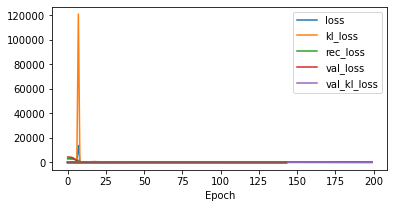

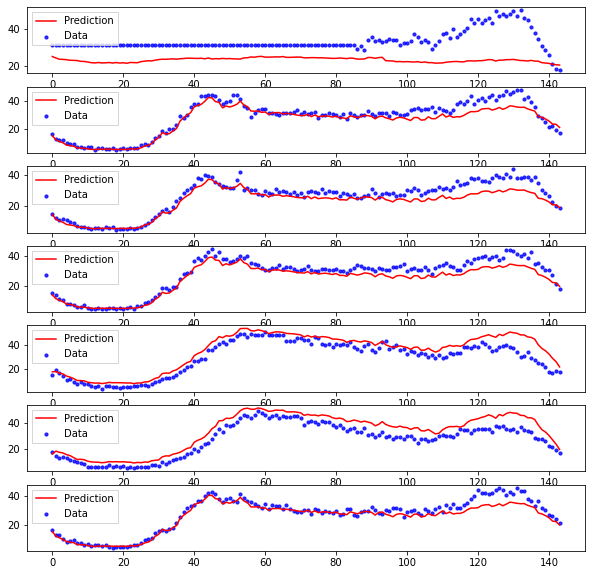

               MSE  R-squared       MAE
Average  43.075687     0.2204  4.943866
                MSE  R-squared        MAE
sample1  140.947632  -3.421810  10.450581
sample2   20.909950   0.867868   3.297774
sample3   23.718559   0.798349   3.667260
sample4   18.296259   0.868425   3.483640
sample5   39.753922   0.794749   5.089786
sample6   44.038765   0.738684   6.049824
sample7   13.864722   0.896538   2.568191


In [130]:
#i = #examples
i = 7

df = pd.read_csv('water_consumption_profiles.csv')

_ = df.values

all_days = _[:,1:].T

all_days.shape

all_days = all_days.astype('float64')

data = all_days[:, :7]



x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:100]).reshape(1, 100, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[100:120]).reshape(1, 20, data.shape[1])
#print(x_val)






dkf = RNDKF(input_dim=i, z_dim=5*i, rnn_dim=5*i, trans_dim=5*i, emission_dim=5*i)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')


# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 50)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)


fig, ax = plt.subplots(i, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    #axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
    #                facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)


## 5 first workouts by altitude SNDKF

Epoch= 1/200, loss= 2723.746, mse= 2695.151, kld= 285.950
	val_loss= 412.340, val_mse= 411.411, val_kld= 9.293
Epoch= 11/200, loss= 449.109, mse= 442.202, kld= 69.073
	val_loss= 117.551, val_mse= 114.303, val_kld= 32.481
Epoch= 21/200, loss= 375.882, mse= 370.567, kld= 53.154
	val_loss= 113.725, val_mse= 111.397, val_kld= 23.277
Epoch= 31/200, loss= 341.949, mse= 338.155, kld= 37.937
	val_loss= 92.765, val_mse= 90.792, val_kld= 19.729
Epoch= 41/200, loss= 261.838, mse= 258.633, kld= 32.043
	val_loss= 63.241, val_mse= 61.327, val_kld= 19.142
Epoch= 51/200, loss= 191.784, mse= 188.273, kld= 35.118
	val_loss= 52.515, val_mse= 50.492, val_kld= 20.237
Epoch= 61/200, loss= 162.849, mse= 159.988, kld= 28.608
	val_loss= 45.661, val_mse= 43.901, val_kld= 17.597
Epoch= 71/200, loss= 147.097, mse= 144.598, kld= 24.981
	val_loss= 36.539, val_mse= 34.971, val_kld= 15.684
Epoch= 81/200, loss= 110.806, mse= 108.491, kld= 23.153
	val_loss= 33.065, val_mse= 31.532, val_kld= 15.324
Epoch= 91/200, loss= 

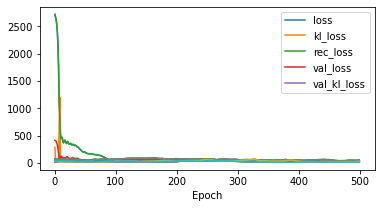

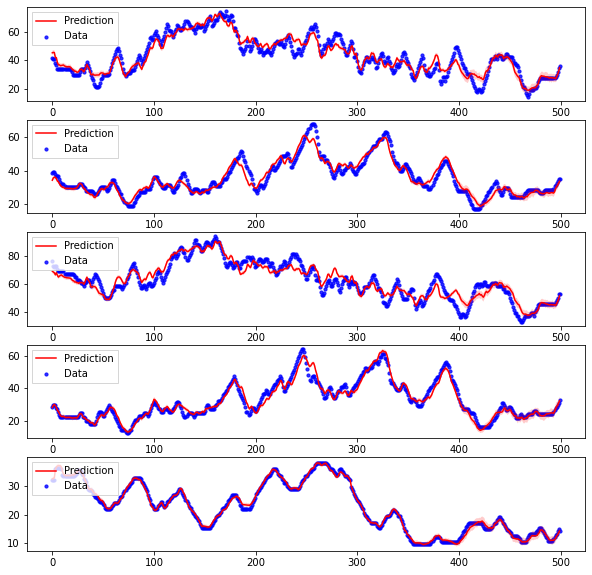

              MSE  R-squared       MAE
Average  11.76773   0.923482  2.467848
               MSE  R-squared       MAE
sample1  18.407692   0.898636  3.491214
sample2   9.176114   0.914770  2.398109
sample3  23.859688   0.863427  3.962124
sample4   6.984386   0.946422  2.004938
sample5   0.410771   0.994156  0.482857


In [132]:
data = np.vstack([np.asarray(data_endo[0]['altitude']), np.asarray(data_endo[1]['altitude']), 
                  np.asarray(data_endo[2]['altitude']), np.asarray(data_endo[3]['altitude']),
                  np.asarray(data_endo[4]['altitude'])]).T
#print(data.shape)

x = torch.FloatTensor(data).reshape(1, *data.shape)
#print(x)
x_train = torch.FloatTensor(data[:450]).reshape(1, 450, data.shape[1])
#print(x_train)
x_val   = torch.FloatTensor(data[450:500]).reshape(1, 50, data.shape[1])
#print(x_val)

dkf = RNDKF(input_dim=5, z_dim=25, rnn_dim=25, trans_dim=25, emission_dim=25)

history, param_dict = dkf.fit(x_train, x_val, num_epochs=200, annealing_factor=0.1)

pd.DataFrame(history).plot(figsize=(6, 3), xlabel='Epoch')

# x_hat = dkf.generate(x_train)
# x_hat, x_025, x_975 = dkf.filter(x_train)
x_hat, x_025, x_975 = dkf.predict(x, 100)
x_hat = x_hat.detach().numpy()[0]
x_025 = x_025.detach().numpy()[0]
x_975 = x_975.detach().numpy()[0]
plt.plot(x_hat)
plt.plot(x_975)
plt.plot(x_025)

fig, ax = plt.subplots(5, figsize=(10, 10))

for i, axi in enumerate(ax):
    axi.scatter(
        np.arange(data.shape[0]),
        data[:, i], s=10, alpha=0.8, label='Data', c='b')
    axi.plot(x_hat[:, i], label='Prediction', c='r')
    axi.fill_between(np.arange(x_hat.shape[0]), x_025[:, i], x_975[:, i],
                    facecolor='r', alpha=0.2)
    
    axi.legend(loc='upper left', fancybox=False)
plt.show()


mse_values = mean_squared_error(x[0], x_hat)
r_squared_values = r2_score(x[0], x_hat)
mae_values = mean_absolute_error(x[0], x_hat)

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=['Average'])

# Print the DataFrame
print(df)

mse_values = mean_squared_error(x[0], x_hat, multioutput='raw_values')
r_squared_values = r2_score(x[0], x_hat, multioutput='raw_values')
mae_values = mean_absolute_error(x[0], x_hat, multioutput='raw_values')

num_samples = x_hat.shape[1]  # Number of samples

# Create a dictionary with the evaluation metrics
data = {
    'MSE': mse_values,
    'R-squared': r_squared_values,
    'MAE': mae_values
}

# Create a DataFrame from the dictionary with appropriate column names
df = pd.DataFrame(data, index=[f"sample{i+1}" for i in range(num_samples)])

# Print the DataFrame
print(df)